### General information referring to some of the code

**patsy**
*Generating design matrices*
We include the intercept once in the model via the intercept parameter, to prevent having additional '1' columns in basis functions include_intercept is set to False and automatic creation of '1' column of patsy is prevented by '-1' in the formula.

*Passing design matrices to PyMc/ Stan*
For the spline regression we generate our design matrices using patsy. This returns an object of the class 'DesignMatrix' which contains additional metadata comparede to a numpy array. However in comparioson to numpy arrays, those objects of the DesignMatrix clss do not support pickling.
Therefore we convert the matrices to numpy arrays by np.asarray() - essentially dropping the metadata - before passing them to the model.
THe additional argument order="F" is used to have the array in Fortran order which is preferred by PyMC3 and Stan.

**Understanding posterior predictives and cross validation**
(1) We specify a model and incorporate some prior belief for the model parameters.
(2) Using the training data and the MCMC algorithm we update our prior beliefs to better represent the data we obeserve. Thereby we obtain posterior distributions for our model parameters.
(3) With new data (our evaluation set), we can verify our model. Notice, that the posterior distributions of all parameters we defined in our model remain unchanged. In our specific example only mu is individual for each parameter as it is dependent on the covariates of a observation. This explains how we obtain a different mu for every obeservation if the covariates aren't identical. To verify the model we draw samples from the posterior distribution of each observation and calculate the CRPS.
(how are the posterior predictive samples obtained: we draw a set of paramters based on their underlying posterior distribution and use those to draw one sample. This is repeated several times to reflect the uncertainty within  the posteriors for this obeservation.

**Implementing cross validation**
PyStan: Add corresponding code to the 'generate quantities block' to generate the posterior predictive samples based on obtained posteriors and new data
PyMc: Define covariates as "theano.shared" variables before feeding them into the model and integrate evaluation data via the "set_value()" function. Afterwards, pm.sample_posterior_predictive() will generate predictives for the evaluation data only. 

**Transforming data**
According to Bretzger, Lang (2004) it is desirable to standardize out target variable as "the amount of smoothness allowed by a particular prior specification depends (weakly) on the scale of the responses". However, initially in Stan this rose an error originating from working with a negative binomial distribution. Further inspection is necessary.

**Defining knots for splines**
So far we use equally-spaced knots for our spline regression. As our data is zero-inflated and overdispersed this leads to having the majority of the data within a minorty of the knots. Quantile-based knots are therefore a valid option. However, the P-Splines definition through a penalty matrix is not compatible with quantile-based knots. For an integration of quantile-based knots further investigation is necessary.

## I. Prerequisites

**1. Import Packages**

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import time

from data_gathering import gather_data_actuals, gather_data_features
from data_preparation import preprocess_data, generate_knots, generate_spline_design_matrix
from data_exploration import calculate_data_characteristics
from data_modelling_bayes import calculate_crps, generate_penalty_matrix
from data_logging import generate_all_dictionaries, ml_flow_tracking, count_divergences
from help_functions import MLFlowServer
from importlib import reload

ModuleNotFoundError: No module named 'data_modelling_bayes'

In [ ]:
import help_functions
reload(help_functions)
from help_functions import MLFlowServer

In [ ]:
pymc = False
stan = True
example_export = False
start_server = True
stop_server = False

**PyMc specific packages**

In [ ]:
if pymc:
    import pymc as pm

**PyStan specific packages**

In [ ]:
if stan:
    import pystan

In [2]:
from help_functions import MLFlowServer
if start_server:
    # Start mlflow server: Necessary before every first mlflow_logging
    server = MLFlowServer(experiment_name="baseline_model")
    server.start()

2023/09/15 10:54:26 INFO mlflow.tracking.fluent: Experiment with name 'baseline_model' does not exist. Creating a new experiment.


In [17]:
server.stop()

KeyboardInterrupt: 

**2. Define functions**

**3. Set style and generate random seed**

In [25]:
az.style.use("arviz-darkgrid")
RANDOM_SEED = 58

## II. Data Preparation

### 1. Load data

In [2]:
from data_gathering import gather_data_actuals, gather_data_features

In [3]:
data_cm_actual_2018, data_cm_actual_2019, data_cm_actual_2020, data_cm_actual_2021, data_cm_actual_allyears \
    = gather_data_actuals()
# Load features data
data_cm_features_2017, data_cm_features_2018, data_cm_features_2019, data_cm_features_2020, data_cm_features_allyears \
    = gather_data_features()

In [4]:
import seaborn as sns

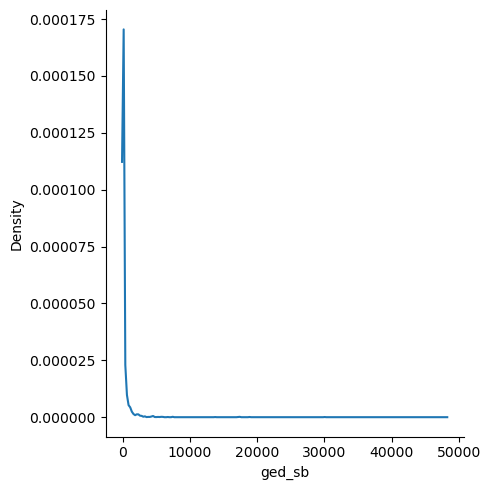

In [26]:
sns.displot(data_cm_features_allyears, x="ged_sb", kind='kde')

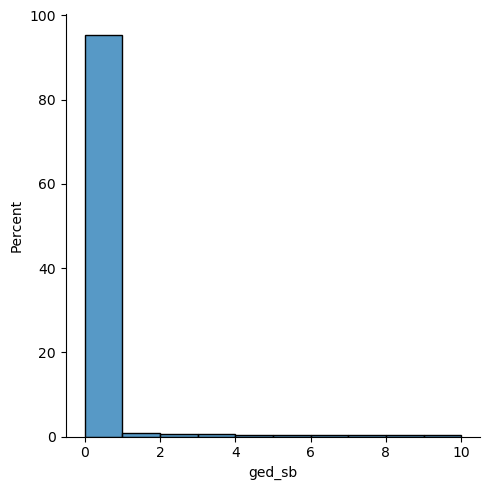

In [17]:
sns.displot(data_cm_features_allyears[(data_cm_features_allyears["ged_sb"] >= 0) & (data_cm_features_allyears["ged_sb"] <= 10)] , x="ged_sb", stat= 'percent')

In [24]:
data_cm_features_allyears.where(data_cm_features_allyears["ged_sb"] == 0)['ged_sb'].count()/data_cm_features_allyears['ged_sb'].count()

0.8741744772891132

In [23]:
data_cm_features_allyears.where(data_cm_features_allyears["ged_sb"] <= 10)['ged_sb'].count()/data_cm_features_allyears['ged_sb'].count()

0.9156164383561644

In [25]:
data_cm_features_allyears.where(data_cm_features_allyears["ged_sb"] <= 100)['ged_sb'].count()/data_cm_features_allyears['ged_sb'].count()

0.9697332372025955

In [7]:
data_cm_features_allyears[data_cm_features_allyears["ged_sb"] > 0]

,index,month_id,country_id,gleditsch_ward,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,...,ind_efficiency_t48,irr_agr_efficiency_t48,services_efficiency_t48,general_efficiency_t48,water_stress_t48,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5
12,12,121,13,135,40.0,0.0,46.0,0.0,0.0,0.0,...,163.805199,0.442221,28.704283,8.900749,2.526080,81115.613030,92919.640082,1.125000,1.125000,0.156250
14,14,121,16,90,4.0,0.0,4.0,0.0,0.0,0.0,...,28.325424,0.822689,152.263548,13.320578,4.193121,12940.529026,15157.720400,1.118181,0.149431,0.149431
26,26,121,28,100,63.0,0.0,44.0,0.0,0.0,0.0,...,109.220746,0.242500,37.667789,17.207321,1.159581,70161.142973,77193.611849,2.093750,2.036814,1.096532
31,31,121,33,93,2.0,0.0,0.0,0.0,0.0,0.0,...,42.764326,0.051560,19.054314,3.625679,2.241452,40859.191291,43032.802965,0.062500,0.062500,0.062500
37,37,121,39,200,3.0,0.0,0.0,0.0,0.0,0.0,...,66.560878,0.642410,142.959702,225.677975,19.785166,2565.349946,2600.734083,0.031250,0.031250,0.031250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69334,2276,490,214,483,16.0,0.0,0.0,13.0,2.0,1.0,...,28.259042,0.043381,50.743225,9.347084,4.294922,1030.102337,3138.378454,5.723309,5.091178,4.754279
69336,2278,490,220,652,178.0,45.0,0.0,319.0,455.0,147.0,...,8.831977,0.099195,6.188813,0.955758,124.360139,408.346132,962.006690,4.021780,2.142599,1.264962
69337,2279,490,222,651,36.0,0.0,1.0,21.0,24.0,16.0,...,83.273336,0.627865,18.108030,4.437605,110.473588,10.587941,608.806585,2.610032,1.167240,2.021468
69338,2280,490,223,750,47.0,0.0,9.0,33.0,62.0,36.0,...,33.212701,0.396672,20.761684,2.628359,66.492093,1091.718512,1442.714318,2.526302,1.499522,0.840567


### 2. Define model specifications corresponding to mlflow log

**Data used in model**

In [6]:
predictors = ['ged_sb_tlag_1', 'ged_sb_tsum_24']
target_variable = ['ged_sb']
country_name = 'Syria'
df_Y_non_std_X_std, df_Y_std_X_std, df_Y_non_std_X_std_log, df_Y_std_X_std_log = (preprocess_data(data_cm_features_allyears, predictors, target_variable, country_name))
df = df_Y_non_std_X_std

C:\Users\Uwe Drauz\anaconda3\envs\bachelor_thesis_pystan_clean\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
# Note: Prelimanary definition of evaluation data till better integration of cross validation
# Take last 24 obeservations of training data a
df_eval = df.iloc[-24:]
# Select 3rd till 14th observation (equals year 2019 here) as evaluation data
df_eval = df_eval.iloc[3:14]
# Cut the last 24 observations from the training data
df = df.iloc[:-24]

In [8]:
dataX1 = df.ged_sb_tlag_1.to_numpy()
dataX2 = df.ged_sb_tsum_24.to_numpy()
dataY = df.ged_sb.to_numpy()
dataY_df = pd.DataFrame(df["ged_sb"])
data_characteristics_train = calculate_data_characteristics(df)

In [9]:
dataX1_eval = df_eval.ged_sb_tlag_1.to_numpy()
dataX2_eval = df_eval.ged_sb_tsum_24.to_numpy()
dataY_eval = df_eval.ged_sb.to_numpy()
dataY_eval_df = pd.DataFrame(df_eval["ged_sb"])
data_characteristics_eval = calculate_data_characteristics(df_eval)

In [10]:
data_transformation = "target variable not standardized, input data standardized"

In [14]:
# Export to test in R
if example_export:
    df.to_parquet(fr'C:\Users\Uwe Drauz\Documents\bachelor_thesis_local\personal_competition_data\fatality_data_{country_name}.parquet')


### 3. Model description

In [11]:
model_name_gauss = 'bayesian_regression'
model_name_nb_half_normal = 'bayesian_regression'
model_name_nb_gamma = 'bayesian_regression'
model_name_splines = 'bayesian_spline_regression'
model_name_penalized_splines_grw = 'bayesian_penalized_spline_regression_gaussian_random_walk'
model_name_penalized_splines_penalty = 'bayesian_penalized_spline_regression_penalty_potential'

In [12]:
prior_specifications_gauss = {
    "intercept": "Normal",
    "slopesX1": "Normal", 
    "slopesX2": "Normal", 
    "likelihood": "Gaussian",
    "sigma": "Normal", 
}
prior_specifications_nb_half_normal = {
    "intercept": "Normal",
    "slopesX1": "Normal", 
    "slopesX2": "Normal", 
    "likelihood": "NegativeBinomial",
    "alpha": "HalfNormal", 
}
prior_specifications_nb_gamma = {
    "intercept": "Normal",
    "slopesX1": "Normal", 
    "slopesX2": "Normal", 
    "likelihood": "NegativeBinomial",
    "alpha": "Gamma", 
}
prior_specifications_splines = {
    "intercept": "Normal",
    "slopesX1": "Normal", 
    "slopesX2": "Normal", 
    "likelihood": "NegativeBinomial",
    "alpha": "Gamma", 
}
prior_specifications_penalized_splines_grw = {
    "intercept": "Normal",
    "inital_distribution": "Normal",
    "slopesX1": "GaussianRandomWalk", 
    "tauX1": "InverseGamma",
    "slopesX2": "GaussianRandomWalk", 
    "tauX2": "InverseGamma",
    "likelihood": "NegativeBinomial",
    "alpha": "Gamma", 
}
prior_specifications_penalized_splines_penalty = {
    "intercept": "Normal",
    "slopesX1_0": "Normal",
    "slopesX1_rest": "Normal", 
    "tauX1": "InverseGamma",
    "slopesX2_0": "Normal",
    "slopesX2_rest": "Normal", 
    "tauX2": "InverseGamma",
    "likelihood": "NegativeBinomial",
    "alpha": "Gamma", 
}

### 4. Model hyperparameters

In [13]:
# PARAMETERS RELATED TO SPLINES
num_knots_X1 = 10
num_knots_X2 = 10
spline_degree = 3
no_spline_coefficients_X1 = num_knots_X1 + spline_degree
no_spline_coefficients_X2 = num_knots_X2 + spline_degree

In [14]:
# name scheme: y ~ dist1(z), x ~ dist2(y)
# opt(component name) + dist1 + z + dist2 + y
# PARAMETERS RELATED TO PRIORS
# Define variables for tau priors
tauX1_ig_alpha_gaussian_sigma = tauX2_ig_alpha_gaussian_sigma = 1
tauX1_ig_beta_gaussian_sigma = tauX2_ig_beta_gaussian_sigma = 0.005

# Define variables for alpha prior of gamma distribution of alpha of negative binomial distribution
gamma_alpha_nb_alpha = 0.1
gamma_beta_nb_alpha = 0.1

# Define variables for prior distribution of intercept
intercept_gaussian_mu = 0
intercept_gaussian_sigma = 5

# Define standard deviation for Half Normal distribution of  alpha parameter of likelihood negative binomial distribution
hgaussian_sigma_nb_alpha = 2.5

# Define standard deviation for Normal distribution of sigma of likelihood gaussian distribution
gaussian_sigma_gaussian_sigma = 2.5

# Define parameters for gaussian distribution of regression coefficients
beta_gaussian_mu = 0.0
beta_gaussian_sigma = 1.0

# Define paramters for half gaussian distribution of intercepts
intercept_hgaussian_mu = 0
intercept_hgaussian_sigma = 1

# Define parameters for beta diffuse prior
diffuse_prior_beta_mu = 0
diffuse_prior_beta_sigma = 100

# Define sigma of half gaussian distribution of sigma for gaussian likelihood
hgaussian_sigma_gaussian_sigma = 2.5

### 5. Sampling hyperparameters

In [15]:
# Define number of tuning iterations
tune_default = 2000
# Define number of sampling iterations
draws_default = 1000
# Define target acceptance rate
target_accept_default = 0.95
# Define number of chains
no_chains_default = 4
# Define number of posterior predictive samples
no_ppc_samples_default = 500

In [16]:
# Define dictionary for implicit handling of data in PyMc
COORDS_gauss = {"predictors": ['ged_sb_tlag_1', 'ged_sb_tsum_24'], "obs_idx": df.index}
COORDS_nb_half_normal = {"predictors": ['ged_sb_tlag_1', 'ged_sb_tsum_24'], "obs_idx": df.index}
COORDS_nb_gamma = {"predictors": ['ged_sb_tlag_1', 'ged_sb_tsum_24'], "obs_idx": df.index}
COORDS_splines = {"obs_idx": df.index, "splines_x1": np.arange(no_spline_coefficients_X1), "splines_x2": np.arange(no_spline_coefficients_X2)}
COORDS_penalized_splines_rw = {"obs_idx": df.index, "splines_x1": no_spline_coefficients_X1, "splines_x2": no_spline_coefficients_X2}
COORDS_penalized_splines_penalty = \
    {"obs_idx": df.index, "splines_x1_rest": np.arange(no_spline_coefficients_X1 -1), "splines_x2_rest": np.arange(no_spline_coefficients_X2 -1)}

### 6. Calculate design matrices for implementation of splines

In [33]:
# We define the knot list such that we'll have num_knots knot inbetween the boundaries of the data
knot_list_X1 = generate_knots(dataX1, num_knots_X1)
knot_list_X2 = generate_knots(dataX2, num_knots_X2)

# Define the basis functions
basis_X1 = generate_spline_design_matrix(dataX1, knot_list_X1, spline_degree)
basis_X2 = generate_spline_design_matrix(dataX2, knot_list_X2, spline_degree)

# Define the penalty matrices
K_X1 = generate_penalty_matrix(basis_X1.shape[1])
K_X2 = generate_penalty_matrix(basis_X2.shape[1])

if basis_X1.shape[1] != no_spline_coefficients_X1:
    print("Number of coefficients as per basis function of regressor 1 did not match predefined number of coefficients in spline. Changed it by considering dimensions of basis design matrix")
    no_spline_coefficients_X1 = basis_X1.shape[1]
if basis_X2.shape[1] != no_spline_coefficients_X2:
    print("Number of coefficients as per basis function of regressor 2 did not match predefined number of coefficients in spline. Changed it by considering dimensions of basis design matrix")
    no_spline_coefficients_X2 = basis_X2.shape[1]

# Define the design matrices for the evaluation data
knot_list_X1_eval = generate_knots(dataX1_eval, num_knots_X1)
knot_list_X2_eval = generate_knots(dataX2_eval, num_knots_X2)

basis_X1_eval = generate_spline_design_matrix(dataX1_eval, knot_list_X1_eval, spline_degree)
basis_X2_eval = generate_spline_design_matrix(dataX2_eval, knot_list_X2_eval, spline_degree)


KeyboardInterrupt: 

## III.1 PyMc Model Building

### 1. Build Bayesian model with Gaussian distribution

In [ ]:
start= time.time()
with pm.Model(coords=COORDS_gauss) as bayesian_model_gauss:
    # Define the priors for regressors and standard deviation
    intercept = pm.Normal('intercept', intercept_gaussian_mu, intercept_gaussian_sigma)
    beta = pm.Normal("slopes", beta_gaussian_mu, beta_gaussian_sigma, dims="predictors")
    sigma = pm.HalfNormal("sigma", hgaussian_sigma_gaussian_sigma)

    # Specify the data
    X1 = pm.ConstantData("fatality lag t=1", dataX1, dims="obs_idx")
    X2 = pm.ConstantData("fatality rolling average t=24", dataX2, dims="obs_idx")
    Y = pm.ConstantData("fatility count", dataY, dims="obs_idx")

    # Specify mean of gaussian distribution
    mu = intercept +  beta[0] * X1 + beta[1] * X2
    # mean for target variable
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=Y, dims="obs_idx")

    # Run the sampling using the No-U-Turn Sampler (NUTS) for the specified number of samples
    idata_bayesian_gauss = pm.sample(draws=draws_default, tune=tune_default, random_seed=RANDOM_SEED, target_accept=target_accept_default)

sampling_time_gauss = time.time() - start

In [ ]:
with bayesian_model_gauss:
    ppc_prior_gauss = pm.sample_prior_predictive(no_ppc_samples_default, random_seed=RANDOM_SEED)
    ppc_posterior_gauss = pm.sample_posterior_predictive(idata_bayesian_gauss, extend_inferencedata=True, random_seed=RANDOM_SEED)

In [ ]:
crps_gauss, crps_average_gauss = calculate_crps(idata_bayesian_gauss, actuals=dataY_df, posterior_predictive='obs');

In [ ]:
# Create dictionary of parameters used in the model:
all_dictionaries_gauss = generate_all_dictionaries(
    training_data=df, 
    evaluation_data=df_eval,
    data_characteristics_train=data_characteristics_train, 
    data_characteristics_eval=data_characteristics_eval,
    data_transformation=data_transformation, 
    country_name=country_name, 
    predictors=predictors, 
    model_name=model_name_gauss, 
    prior_specifications=prior_specifications_gauss,
    intercept_hyperparameters= (intercept_gaussian_mu, intercept_gaussian_sigma),
    beta_hyperparameters=(beta_gaussian_mu, beta_gaussian_sigma),
    sigma_gaussian_hyperparameters=hgaussian_sigma_gaussian_sigma,
    tuning_iterations=tune_default,
    sampling_iterations=draws_default,
    target_acceptance_rate=target_accept_default,
    chains=no_chains_default,
    sampling_time=sampling_time_gauss, 
    idata=idata_bayesian_gauss,
    crps_score_train=crps_average_gauss,
    crps_score_eval=crps_average_gauss)
ml_flow_tracking(**all_dictionaries_gauss)

### 2. Build Bayesian model with Negative Binomial distribution (alpha HalfNormal distributed)

In [ ]:
# Build the model
start = time.time()
with pm.Model(coords=COORDS_nb_half_normal) as bayesian_model_nb_half_normal:
    # Define the priors for regressors and  negative binomial over-dispersion parameter
    intercept = pm.Normal("intercept", mu=intercept_gaussian_mu, sigma=intercept_gaussian_sigma)
    beta = pm.Normal("slopes", beta_gaussian_mu, beta_gaussian_sigma, dims="predictors")
    alpha = pm.HalfNormal('alpha', sigma=hgaussian_sigma_nb_alpha)

    # Specify the data
    X1 = pm.ConstantData("fatality lag t=1", dataX1, dims="obs_idx")
    X2 = pm.ConstantData("fatality rolling average t=24", dataX2, dims="obs_idx")
    Y = pm.ConstantData("fatility count", dataY, dims="obs_idx")

    # Note: Possibly an option to change to pm.Deterministic
    # Define mean of negative binomial distribution
    mu = pm.math.exp(intercept + beta[0] * X1 + beta[1] * X2)

    # Define the likelihood
    obs = pm.NegativeBinomial("obs", mu=mu, alpha=alpha, observed=Y, dims="obs_idx")

    # Note: Optionally define cores and chains
    # Run the sampling using the No-U-Turn Sampler (NUTS) for the specified number of samples
    idata_bayesian_nb_half_normal = pm.sample(draws=draws_default, tune=tune_default, random_seed=RANDOM_SEED, target_accept=target_accept_default)

sampling_time_nb_half_normal = time.time() - start

In [ ]:
try:
    with bayesian_model_nb_half_normal:
        ppc_posterior_nb_half_normal = pm.sample_posterior_predictive(idata_bayesian_nb_half_normal, extend_inferencedata=True, random_seed=RANDOM_SEED)
except Exception as error:
    print("Error", error)
try:
    with bayesian_model_nb_half_normal:
        ppc_prior_nb_half_normal = pm.sample_prior_predictive(no_ppc_samples_default, random_seed=RANDOM_SEED)
except Exception as error:
    print("Error", error)

In [ ]:
crps_nb_half_normal, crps_average_nb_half_normal = calculate_crps(idata_bayesian_nb_half_normal, actuals=dataY_df, posterior_predictive='obs');

In [ ]:
# Create dictionary of parameters used in the model:
all_dictionaries_nb_half_normal = generate_all_dictionaries(
    training_data=df, 
    evaluation_data=df_eval,
    data_characteristics_train=data_characteristics_train, 
    data_characteristics_eval=data_characteristics_eval,
    data_transformation=data_transformation, 
    country_name=country_name, 
    predictors=predictors, 
    model_name=model_name_nb_half_normal, 
    prior_specifications=prior_specifications_nb_half_normal,
    alpha_nb_hyperparameters=hgaussian_sigma_nb_alpha,
    intercept_hyperparameters= (intercept_gaussian_mu, intercept_gaussian_sigma),
    beta_hyperparameters=(beta_gaussian_mu, beta_gaussian_sigma),
    tuning_iterations=tune_default,
    sampling_iterations=draws_default,
    target_acceptance_rate=target_accept_default,
    chains=no_chains_default,
    sampling_time=sampling_time_nb_half_normal, 
    idata=idata_bayesian_nb_half_normal,
    crps_score_train=crps_average_nb_half_normal,
    crps_score_eval=crps_average_nb_half_normal)
ml_flow_tracking(**all_dictionaries_nb_half_normal)

### 3. Build Bayesian model with Negative Binomial distribution (alpha Gamma distributed)

In [ ]:
# Build the model
start = time.time()
with pm.Model(coords=COORDS_nb_gamma) as bayesian_model_nb_gamma:
    # Define the priors for regressors and  negative binomial over-dispersion parameter
    intercept = pm.Normal("intercept", mu=intercept_gaussian_mu, sigma=intercept_gaussian_sigma)
    beta = pm.Normal("slopes", beta_gaussian_mu, beta_gaussian_sigma, dims="predictors")
    alpha = pm.Gamma('alpha', gamma_alpha_nb_alpha, gamma_beta_nb_alpha)

    # Specify the data
    X1 = pm.ConstantData("fatality lag t=1", dataX1, dims="obs_idx")
    X2 = pm.ConstantData("fatality rolling average t=24", dataX2, dims="obs_idx")
    Y = pm.ConstantData("fatility count", dataY, dims="obs_idx")

    # Note: Possibly an option to change to pm.Deterministic
    # Define mean of negative binomial distribution
    mu = pm.math.exp(intercept + beta[0] * X1 + beta[1] * X2)

    # Define the likelihood
    obs = pm.NegativeBinomial("obs", mu=mu, alpha=alpha, observed=Y, dims="obs_idx")

    # Note: Optionally define cores and chains
    # Run the sampling using the No-U-Turn Sampler (NUTS) for the specified number of samples
    idata_bayesian_nb_gamma = pm.sample(draws=draws_default, tune=tune_default, random_seed=RANDOM_SEED, target_accept=target_accept_default)

sampling_time_nb_gamma = time.time() - start

In [ ]:
try:
    with bayesian_model_nb_gamma:
        ppc_posterior_nb_gamma = pm.sample_posterior_predictive(idata_bayesian_nb_gamma, extend_inferencedata=True, random_seed=RANDOM_SEED)
except Exception as error:
    print("Error", error)
try:
    with bayesian_model_nb_gamma:
        ppc_prior_nb_gamma = pm.sample_prior_predictive(no_ppc_samples_default, random_seed=RANDOM_SEED)
except Exception as error:
    print("Error", error)

In [ ]:
crps_nb_gamma, crps_average_nb_gamma = calculate_crps(idata_bayesian_nb_gamma, actuals=dataY_df, posterior_predictive='obs');

In [ ]:
# Create dictionary of parameters used in the model:
all_dictionaries_nb_gamma = generate_all_dictionaries(
    training_data=df, 
    evaluation_data=df_eval,
    data_characteristics_train=data_characteristics_train, 
    data_characteristics_eval=data_characteristics_eval,
    data_transformation=data_transformation,
    country_name=country_name, 
    predictors=predictors, 
    model_name=model_name_nb_gamma, 
    prior_specifications=prior_specifications_nb_gamma,
    alpha_nb_hyperparameters=(gamma_alpha_nb_alpha, gamma_beta_nb_alpha),
    intercept_hyperparameters= (intercept_gaussian_mu, intercept_gaussian_sigma),
    beta_hyperparameters=(beta_gaussian_mu, beta_gaussian_sigma),
    tuning_iterations=tune_default,
    sampling_iterations=draws_default,
    target_acceptance_rate=target_accept_default,
    chains=no_chains_default,
    sampling_time=sampling_time_nb_gamma, 
    idata=idata_bayesian_nb_gamma,
    crps_score_train=crps_average_nb_gamma,
    crps_score_eval=crps_average_nb_gamma)
ml_flow_tracking(**all_dictionaries_nb_gamma)

### 4. Build Bayesian model with Negative Binomial distribution (alpha Gamma distributed) and regression splines (B-Splines)

In [ ]:
# Build the model
start = time.time()
with pm.Model(coords=COORDS_splines) as bayesian_model_nb_gamma_splines:
    # Specify the data
    X1 = pm.ConstantData("fatality lag t=1", dataX1, dims="obs_idx")
    X2 = pm.ConstantData("fatality rolling average t=24", dataX2, dims="obs_idx")
    Y = pm.ConstantData("fatility count", dataY, dims="obs_idx")


    # Define the priors for regressors and  negative binomial over-dispersion parameter
    intercept = pm.Normal("intercept", mu=intercept_hgaussian_mu, sigma=intercept_hgaussian_sigma)
    beta_X1 = pm.Normal("slopesX1", beta_gaussian_mu, beta_gaussian_sigma, dims="splines_x1")
    beta_X2 = pm.Normal("slopesX2", beta_gaussian_mu, beta_gaussian_sigma, dims="splines_x2")
    alpha = pm.Gamma('alpha', gamma_alpha_nb_alpha, gamma_beta_nb_alpha)
    
    # Define mean of negative binomial distribution
    mu = pm.math.exp(intercept + pm.math.dot(np.asarray(basis_X1, order="F"), beta_X1.T) + pm.math.dot(np.asarray(basis_X2, order="F"), beta_X2.T))

    # Define the likelihood
    obs = pm.NegativeBinomial("obs", mu=mu, alpha=alpha, observed=Y, dims="obs_idx")

    # Note: Optionally define cores and chains
    # Run the sampling using the No-U-Turn Sampler (NUTS) for the specified number of samples
    idata_bayesian_nb_gamma_splines = pm.sample(draws=draws_default, tune=tune_default, random_seed=RANDOM_SEED, target_accept=target_accept_default)

sampling_time_nb_gamma_splines = time.time() - start

In [ ]:
try:
    with bayesian_model_nb_gamma_splines:
        ppc_posterior_nb_gamma_splines = pm.sample_posterior_predictive(idata_bayesian_nb_gamma_splines, extend_inferencedata=True, random_seed=RANDOM_SEED)
except Exception as error:
    print("Error", error)
try:
    with bayesian_model_nb_gamma_splines:
        ppc_prior_nb_gamma_splines = pm.sample_prior_predictive(no_ppc_samples_default, random_seed=RANDOM_SEED)
except Exception as error:
    print("Error", error)

In [ ]:
crps_nb_gamma_splines, crps_average_nb_gamma_splines = calculate_crps(idata_bayesian_nb_gamma_splines, actuals=dataY_df, posterior_predictive='obs');

In [ ]:
# Create dictionary of parameters used in the model:
all_dictionaries_splines = generate_all_dictionaries(
    training_data=df, 
    evaluation_data=df_eval,
    data_characteristics_train=data_characteristics_train, 
    data_characteristics_eval=data_characteristics_eval,
    data_transformation=data_transformation, 
    country_name=country_name, 
    predictors=predictors, 
    model_name=model_name_splines, 
    prior_specifications=prior_specifications_splines,
    alpha_nb_hyperparameters=(gamma_alpha_nb_alpha, gamma_beta_nb_alpha),
    intercept_hyperparameters= (intercept_gaussian_mu, intercept_gaussian_sigma),
    tuning_iterations=tune_default,
    sampling_iterations=draws_default,
    target_acceptance_rate=target_accept_default,
    chains=no_chains_default,
    sampling_time=sampling_time_nb_gamma_splines, 
    idata=idata_bayesian_nb_gamma_splines,
    crps_score_train=crps_average_nb_gamma_splines,
    crps_score_eval=crps_average_nb_gamma_splines)
ml_flow_tracking(**all_dictionaries_splines)

### 5. Build Bayesian model with Negative Binomial distribution (alpha Gamma distributed) and penalized regression splines with gaussin random walk

In [ ]:
# NOTE: WIP: Implementation of penalized regression splines still to be figured out, Version with Gaussian Random Walk
# Track the time it takes o sample model
start_time = time.time()
# Build the model with random walk
with pm.Model(coords=COORDS_splines) as bayesian_model_nb_gamma_penalized_splines_grw:
    # Specify the data
    X1 = pm.ConstantData("fatality lag t=1", dataX1, dims="obs_idx")
    X2 = pm.ConstantData("fatality rolling average t=24", dataX2, dims="obs_idx")
    Y = pm.ConstantData("fatility count", dataY, dims="obs_idx")


    # Define the priors for regressors and  negative binomial over-dispersion parameter
    intercept = pm.Normal("intercept", mu=intercept_gaussian_mu, sigma=intercept_gaussian_sigma)

    # Define first order random walk to incorporate regularization
    tau_X1 = pm.InverseGamma("tauX1", alpha=tauX1_ig_alpha_gaussian_sigma, beta=tauX1_ig_beta_gaussian_sigma)
    tau_X2 = pm.InverseGamma("tauX2", alpha=tauX2_ig_alpha_gaussian_sigma, beta=tauX2_ig_beta_gaussian_sigma)

    # Define the initial distribution as diffuse prior for the random walk
    initial_distribution_X1 = pm.Normal.dist(mu=diffuse_prior_beta_mu, sigma=diffuse_prior_beta_sigma)
    initial_distribution_X2 = pm.Normal.dist(mu=diffuse_prior_beta_mu, sigma=diffuse_prior_beta_sigma)
    
    # Note: Defining the coefficients in a gaussian random walk should incorporate the penalization of differences of consecutive coefficients
    beta_X1 = pm.GaussianRandomWalk("slopesX1", sigma=tau_X1, shape=basis_X1.shape[1], init_dist=initial_distribution_X1)
    beta_X2 = pm.GaussianRandomWalk("slopesX2", sigma=tau_X2, shape=basis_X2.shape[1], init_dist=initial_distribution_X2)
    alpha = pm.Gamma('alpha', gamma_alpha_nb_alpha, gamma_beta_nb_alpha)

    # Define mean of negative binomial distribution
    # Note: We define the mean of the assumed negative binomial as a linear combination of the basis functions - transformed by a link function to ensure numerical stability
    mu = pm.math.exp(intercept + pm.math.dot(np.asarray(basis_X1, order="F"), beta_X1.T) + pm.math.dot(np.asarray(basis_X2, order="F"), beta_X2.T))

    # Define the likelihood
    # Note: mu is of dimension [N,1] and weighted against the observations in the sampling process
    obs = pm.NegativeBinomial("obs", mu=mu, alpha=alpha, observed=Y, dims="obs_idx")

    # Run the sampling using the No-U-Turn Sampler (NUTS) for the specified number of samples
    idata_bayesian_nb_gamma_penalized_splines_grw = pm.sample(draws=draws_default, tune=tune_default, random_seed=RANDOM_SEED, target_accept=target_accept_default, chains=no_chains_default)
    
sampling_time_psplines_grw = time.time() - start_time

In [ ]:
try:
    with bayesian_model_nb_gamma_penalized_splines_grw:
        ppc_posterior_nb_gamma_penalized_splines = pm.sample_posterior_predictive(idata_bayesian_nb_gamma_penalized_splines_grw, extend_inferencedata=True, random_seed=RANDOM_SEED)
except Exception as error:
    print("Error", error)
try:
    with bayesian_model_nb_gamma_penalized_splines_grw:
        ppc_prior_nb_gamma_penalized_splines = pm.sample_prior_predictive(no_ppc_samples_default, random_seed=RANDOM_SEED)
except Exception as error:
    print("Error", error)

In [ ]:
# Calculate CRPS
crps_nb_gamma_penalized_splines_grw, crps_average_nb_gamma_penalized_splines_grw = calculate_crps(idata_bayesian_nb_gamma_penalized_splines_grw, dataY_df, posterior_predictive='obs')

In [ ]:
# Create dictionary of parameters used in the model:
all_dictionaries_penalized_splines_grw = generate_all_dictionaries(
    training_data=df, 
    evaluation_data=df_eval,
    data_characteristics_train=data_characteristics_train, 
    data_characteristics_eval=data_characteristics_eval,
    data_transformation=data_transformation, 
    country_name=country_name, 
    predictors=predictors, 
    model_name=model_name_penalized_splines_grw, 
    prior_specifications=prior_specifications_splines,
    alpha_nb_hyperparameters=(gamma_alpha_nb_alpha, gamma_beta_nb_alpha),
    intercept_hyperparameters= (intercept_gaussian_mu, intercept_gaussian_sigma),
    no_spline_coefficients_per_regressor=[no_spline_coefficients_X1, no_spline_coefficients_X2],
    tuning_iterations=tune_default,
    sampling_iterations=draws_default,
    target_acceptance_rate=target_accept_default,
    chains=no_chains_default,
    sampling_time=sampling_time_psplines_grw, 
    idata=idata_bayesian_nb_gamma_splines,
    crps_score_train=crps_average_nb_gamma_splines,
    crps_score_eval=crps_average_nb_gamma_splines)
ml_flow_tracking(**all_dictionaries_penalized_splines_grw)

### 6. Build Bayesian model with Negative Binomial distribution (alpha Gamma distributed) and penalized regression splines with penalty potential

In [ ]:
# Track sampling time
start_time = time.time()
# NOTE: WIP: Implementation of penalized regression splines still to be figured out, Version with Penalty deduction in likeihood

with pm.Model(coords=COORDS_penalized_splines_penalty) as bayesian_model_nb_gamma_penalized_splines_penalty:
    # Specify the data
    X1 = pm.ConstantData("fatality lag t=1", dataX1, dims="obs_idx")
    X2 = pm.ConstantData("fatality rolling average t=24", dataX2, dims="obs_idx")
    Y = pm.ConstantData("fatility count", dataY, dims="obs_idx")

    # Define the priors for regressors and negative binomial over-dispersion parameter
    intercept = pm.Normal("intercept", mu=intercept_gaussian_mu, sigma=intercept_gaussian_sigma)

    # Define first order random walk to incorporate regularization
    tau_X1 = pm.InverseGamma("tauX1", alpha=tauX1_ig_alpha_gaussian_sigma, beta=tauX1_ig_beta_gaussian_sigma)
    tau_X2 = pm.InverseGamma("tauX2", alpha=tauX2_ig_alpha_gaussian_sigma, beta=tauX2_ig_beta_gaussian_sigma)

    # Create deterministic variables for squared taus
    tau_X1_squared = pm.Deterministic("tau_X1_squared", tau_X1 ** 2)
    tau_X2_squared = pm.Deterministic("tau_X2_squared", tau_X2 ** 2)
    
    # Note: If this does reflect our intended model remains to be questioned
    # Introduce diffuse priors for the first regression coefficients of the splines with broad gaussian distributions
    beta_X1_0 = pm.Normal("slopesX1_0", diffuse_prior_beta_mu, diffuse_prior_beta_sigma)
    beta_X2_0 = pm.Normal("slopesX2_0", diffuse_prior_beta_mu, diffuse_prior_beta_sigma)
    
    # Define remaining betas as normal variables with standard deviation tau
    beta_X1_rest = pm.Normal("slopesX1_rest", beta_gaussian_mu, tau_X1, dims="splines_x1_rest")
    beta_X2_rest = pm.Normal("slopesX2_rest", beta_gaussian_mu, tau_X2, dims="splines_x2_rest")
    
    # Concatenate the flat priors to the beginning of the coefficients
    beta_X1 = pm.Deterministic("slopesX1", pm.math.concatenate([[beta_X1_0], beta_X1_rest]))
    beta_X2 = pm.Deterministic("slopesX2", pm.math.concatenate([[beta_X2_0], beta_X2_rest]))


    alpha = pm.Gamma('alpha', gamma_alpha_nb_alpha, gamma_beta_nb_alpha)

    # Define mean of negative binomial distribution
    mu = pm.math.exp(intercept + pm.math.dot(np.asarray(basis_X1, order="F"), beta_X1.T) + pm.math.dot(np.asarray(basis_X2, order="F"), beta_X2.T))

    # Define the likelihood
    obs = pm.NegativeBinomial("obs", mu=mu, alpha=alpha, observed=Y, dims="obs_idx")

    # Define the penalty term and incorporate it using pm.Potential
    penalty_term_X1 = pm.math.dot(beta_X1.T, pm.math.dot(K_X1, beta_X1)) / (2 * tau_X1_squared)
    penalty_X1 = pm.Potential("penalty_X1", -penalty_term_X1)

    penalty_term_X2 = pm.math.dot(beta_X2.T, pm.math.dot(K_X2, beta_X2)) / (2 * tau_X2_squared)
    penalty_X2 = pm.Potential("penalty_X2", -penalty_term_X2)

    # Run the sampling using the No-U-Turn Sampler (NUTS) for the specified number of samples
    idata_bayesian_nb_gamma_penalized_splines_penalty = pm.sample(draws=draws_default, tune=tune_default, random_seed=RANDOM_SEED, target_accept=target_accept_default, chains=no_chains_default)

sampling_time_psplines_penalty = time.time() - start_time

In [ ]:
try:
    with bayesian_model_nb_gamma_penalized_splines_penalty:
        ppc_posterior_nb_gamma_penalized_splines_penalty = pm.sample_posterior_predictive(idata_bayesian_nb_gamma_penalized_splines_penalty, extend_inferencedata=True, random_seed=RANDOM_SEED)
except Exception as error:
    print("Error", error)
try:
    with bayesian_model_nb_gamma_penalized_splines_penalty:
        ppc_prior_nb_gamma_penalized_splines_penalty = pm.sample_prior_predictive(no_ppc_samples_default, random_seed=RANDOM_SEED)
except Exception as error:
    print("Error", error)

In [ ]:
crps_nb_gamma_penalized_splines_penalty, crps_average_nb_gamma_penalized_splines_penalty = calculate_crps(idata_bayesian_nb_gamma_penalized_splines_penalty, actuals=dataY_df, posterior_predictive='obs');

In [ ]:
# Create dictionary of parameters used in the model:
all_dictionaries = generate_all_dictionaries(
    training_data=df, 
    evaluation_data=df_eval,
    data_characteristics_train=data_characteristics_train, 
    data_characteristics_eval=data_characteristics_eval, 
    data_transformation=data_transformation, 
    country_name=country_name, 
    predictors=predictors, 
    model_name=model_name_penalized_splines_penalty, 
    prior_specifications=prior_specifications_penalized_splines_penalty, 
    no_spline_coefficients_per_regressor=[no_spline_coefficients_X1, no_spline_coefficients_X2],
    tau_hyperparameters=[(tauX1_ig_alpha_gaussian_sigma, tauX1_ig_beta_gaussian_sigma), (tauX2_ig_alpha_gaussian_sigma, tauX2_ig_beta_gaussian_sigma)],
    alpha_nb_hyperparameters=(gamma_alpha_nb_alpha, gamma_beta_nb_alpha),
    intercept_hyperparameters= (intercept_gaussian_mu, intercept_gaussian_sigma),
    tuning_iterations=tune_default,
    sampling_iterations=draws_default,
    target_acceptance_rate=target_accept_default,
    chains=no_chains_default,
    sampling_time=sampling_time_psplines_penalty, 
    idata=idata_bayesian_nb_gamma_penalized_splines_penalty,
    crps_score_train=crps_average_nb_gamma_penalized_splines_penalty,
    crps_score_eval=crps_average_nb_gamma_penalized_splines_penalty)
ml_flow_tracking(**all_dictionaries)

**7. Explore other ways to build Bayesian model with Negative Binomial distribution (alpha Gamma distributed) and penalized regression splines**

In [ ]:
# # NOTE: WIP: Implementation of penalized regression splines still to be figured out, Version with Penalty Matrix
# # Build the model with penalty matrix
# with pm.Model(coords=COORDS_splines) as bayesian_model_nb_gamma_penalized_splines_penalty_K:
#     # Specify the data
#     X1 = pm.ConstantData("fatality lag t=1", dataX1, dims="obs_idx")
#     X2 = pm.ConstantData("fatality rolling average t=24", dataX2, dims="obs_idx")
#     Y = pm.ConstantData("fatility count", dataY, dims="obs_idx")
# 
# 
#     # Define the priors for regressors and  negative binomial over-dispersion parameter
#     intercept = pm.HalfNormal("intercept", sigma=0.1)
# 
#     # Define first order random walk to incorporate regularization
#     tau_X1 = pm.InverseGamma("tauX1", alpha=a_X1, beta=b_X1)
#     tau_X2 = pm.InverseGamma("tauX2", alpha=a_X2, beta=b_X2)
# 
#     # Calculate covariance matrices
#     cov_X1 = at.dot(at.nlinalg.matrix_inverse(K_X1), at.pow(tau_X1, 2))
#     cov_X2 = at.dot(at.nlinalg.matrix_inverse(K_X2), at.pow(tau_X2, 2))
#     
#     # Compute cholesky decompositions of covariance matrices
#     chol_X1 = at.slinalg.cholesky(cov_X1)
#     chol_X2 = at.slinalg.cholesky(cov_X2)
# 
#     # Define multivariate normal distributions
#     beta_X1 = pm.MvNormal("slopesX1", mu=at.zeros(no_X1_coefficients), chol=chol_X1, shape=no_X1_coefficients)
#     beta_X2 = pm.MvNormal("slopesX2", mu=at.zeros(no_X2_coefficients), chol=chol_X2, shape=no_X2_coefficients)
# 
#     alpha = pm.Gamma('alpha', 0.1, 0.1)
# 
#     # Note: Possibly an option to change to pm.Deterministic
#     # Define mean of negative binomial distribution
#     mu = pm.math.exp(intercept + pm.math.dot(at.as_tensor_variable(basis_X1), beta_X1.T) + pm.math.dot(at.as_tensor_variable(basis_X2),beta_X2.T))
# 
#     # Define the likelihood
#     obs = pm.NegativeBinomial("obs", mu=mu, alpha=alpha, observed=Y, dims="obs_idx")
# 
#     # Note: Optionally define cores and chains
#     # Run the sampling using the No-U-Turn Sampler (NUTS) for the specified number of samples
#     idata_bayesian_nb_gamma_penalized_splines_penalty_K = pm.sample(draws=1000, tune=2000, random_seed=RANDOM_SEED, target_accept=0.95)

In [ ]:
# try:
#     with bayesian_model_nb_gamma_penalized_splines_penalty_K:
#         ppc_posterior_nb_gamma_penalized_splines_penalty_K = pm.sample_posterior_predictive(idata_bayesian_nb_gamma_penalized_splines_penalty_K, extend_inferencedata=True, random_seed=RANDOM_SEED)
# except Exception as error:
#     print("Error", error)

In [ ]:
# try:
#     with bayesian_model_nb_gamma_penalized_splines_penalty_K:
#         ppc_prior_nb_gamma_penalized_splines_penalty_K = pm.sample_prior_predictive(no_ppc_samples_default, random_seed=RANDOM_SEED)
# except Exception as error:
#     print("Error", error)

In [ ]:
# # Note: Pending suggestion of ChatGPT to use tau for covariance altough it's part of the sampling process itself
# # Create a covariance matrix using Theano operations
# tau_X1_squared = tau_X1**2
# tau_X1_squared_diag = tt.diag(tau_X1_squared)
# cov_X1 = tt.dot(np.linalg.inv(K_X1), tau_X1_squared_diag)
# 
# tau_X2_squared = tau_X2**2
# tau_X2_squared_diag = tt.diag(tau_X2_squared)
# cov_X2 = tt.dot(np.linalg.inv(K_X2), tau_X2_squared_diag)

## III.2 PyStan Model Building

### Model 1: Negative Binomial distribution (alpha Gamma distributed) and penalized splines via "manual" random walk

Likelihood: negative binomial
Splines: yes
Penalization: first order random walk
Implementation: diffuse prior + manually

In [18]:
definition_stan_model_nb_gamma_penalized_splines_grw = """
data {
    int<lower=0> N;                      // Number of data points
    int<lower=1> num_basis_X1;           // Number of coefficients for P-splines for X1
    int<lower=1> num_basis_X2;           // Number of coefficients for P-splines for X2

    matrix[N, num_basis_X1] basis_X1;    // Basis matrix for regressor X1
    matrix[N, num_basis_X2] basis_X2;    // Basis matrix for regressor X2
    int Y[N];                            // Observed Target variable
    
    real a_tau_X1;                       // Shape parameter for InverseGamma of tau for X1
    real b_tau_X1;                       // Scale parameter for InverseGamma of tau for X1
    real a_tau_X2;                       // Shape parameter for InverseGamma of tau for X2
    real b_tau_X2;                       // Scale parameter for InverseGamma of tau for X2
    real a_alpha;                        // Shape parameter for Gamma of alpha
    real b_alpha;                        // Scale parameter for Gamma of alpha
    real diffuse_prior_mu;                    // Mean of spline coefficient diffuse prior
    real<lower=0> diffuse_prior_sigma;                 // Standard deviation of spline coefficient diffuse prior
    real intercept_mu;                        // Mean of intercept prior
    real<lower=1> intercept_sigma;                     // Standard deviation of intercept prior
    
    int<lower=0> N_eval;                 // Number of data points for evaluation
    matrix[N_eval, num_basis_X1] basis_X1_eval;    // Basis matrix for regressor X1_eval
    matrix[N_eval, num_basis_X2] basis_X2_eval;    // Basis matrix for regressor X2_eval
    int Y_eval[N_eval];                            // Observed Target variable for evaluation
}

parameters {
    vector[num_basis_X1] spline_coefficients_X1;
    vector[num_basis_X2] spline_coefficients_X2;
    real intercept;
    real<lower=0> tau_X1;
    real<lower=0> tau_X2;
    real<lower=0> alpha;
}

transformed parameters {
    vector[N] mu;
    mu = exp(intercept + to_vector(basis_X1 * spline_coefficients_X1) + to_vector(basis_X2 * spline_coefficients_X2));
}

model {
    intercept ~ normal(intercept_mu, intercept_sigma);
    tau_X1 ~ inv_gamma(a_tau_X1, b_tau_X1);
    tau_X2 ~ inv_gamma(a_tau_X2, b_tau_X2);

    spline_coefficients_X1[1] ~ normal(diffuse_prior_mu, diffuse_prior_sigma);      // diffuse prior for first coefficient
    for (i in 2:num_basis_X1) {                     // random walk prior for coefficients
        spline_coefficients_X1[i] ~ normal(spline_coefficients_X1[i-1], tau_X1);
    }
    
    spline_coefficients_X2[1] ~ normal(diffuse_prior_mu, diffuse_prior_sigma);      // diffuse prior for first coefficient
    for (i in 2:num_basis_X2) {                     // random walk prior for coefficients
        spline_coefficients_X2[i] ~ normal(spline_coefficients_X2[i-1], tau_X2);
    }
    
    alpha ~ gamma(0.1, 0.1);
    Y ~ neg_binomial_2(mu, alpha);
}
generated quantities {
    int y_pred_train[N];
    int y_pred_eval[N_eval];
    vector[N_eval] mu_eval;
    
    mu_eval = exp(intercept + to_vector(basis_X1_eval * spline_coefficients_X1) + to_vector(basis_X2_eval * spline_coefficients_X2));
    for (n in 1:N) {
        y_pred_train[n] = neg_binomial_2_rng(mu[n], alpha);
    }
    for (n_eval in 1:N_eval) {
        y_pred_eval[n_eval] = neg_binomial_2_rng(mu_eval[n_eval], alpha);
    }
}
"""

In [19]:
# Compile the model
stan_model_nb_gamma_penalized_splines_grw = pystan.StanModel(model_code=definition_stan_model_nb_gamma_penalized_splines_grw)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_230c9f40206178d84ce58224164f070c NOW.


In [20]:
stan_data_nb_gamma_penalized_splines_grw = {
    "N": len(dataY),
    "num_basis_X1": no_spline_coefficients_X1,
    "num_basis_X2": no_spline_coefficients_X2,
    "basis_X1": np.asarray(basis_X1, order="F"),
    "basis_X2": np.asarray(basis_X2, order="F"),
    "Y": dataY.astype(int),
    "a_tau_X1": tauX1_ig_alpha_gaussian_sigma,
    "b_tau_X1": tauX1_ig_beta_gaussian_sigma,
    "a_tau_X2": tauX2_ig_alpha_gaussian_sigma,
    "b_tau_X2": tauX2_ig_beta_gaussian_sigma,
    "a_alpha": gamma_alpha_nb_alpha,
    "b_alpha": gamma_beta_nb_alpha,
    "diffuse_prior_mu": diffuse_prior_beta_mu,
    "diffuse_prior_sigma": diffuse_prior_beta_sigma,
    "intercept_mu": intercept_gaussian_mu,
    "intercept_sigma": intercept_gaussian_sigma,
    "N_eval": len(dataY_eval),
    "basis_X1_eval": np.asarray(basis_X1_eval, order="F"),
    "basis_X2_eval": np.asarray(basis_X2_eval, order="F"),
    "Y_eval": dataY_eval.astype(int)
}

In [21]:
# Sampling from the model
start_time = time.time()
stan_model_nb_gamma_penalized_splines_grw_sampling = stan_model_nb_gamma_penalized_splines_grw.sampling(data=stan_data_nb_gamma_penalized_splines_grw, iter=draws_default, chains=no_chains_default, seed=RANDOM_SEED, control={"adapt_delta": target_accept_default})
sampling_time_nb_gamma_penalized_splines_grw_stan = time.time() - start_time

In [22]:
idata_bayesian_nb_gamma_penalized_splines_grw_stan = az.from_pystan(
    posterior=stan_model_nb_gamma_penalized_splines_grw_sampling,
    posterior_predictive=["y_pred_train", "y_pred_eval"])

In [26]:
# Note: possibility to export idata as example object
# idata_bayesian_nb_gamma_penalized_splines_grw_stan.to_netcdf("temp_data/idata_bayesian_nb_gamma_penalized_splines_grw_stan.nc")

'temp_data/idata_bayesian_nb_gamma_penalized_splines_grw_stan.nc'

In [ ]:
# Note: possibility to import idata as example object
# idata_bayesian_nb_gamma_penalized_splines_grw_stan = az.from_netcdf("temp_data/idata_bayesian_nb_gamma_penalized_splines_grw_stan.nc")

In [23]:
crps_train_nb_gamma_penalized_splines_grw_stan, crps_train_average_nb_gamma_penalized_splines_grw_stan = calculate_crps(idata_bayesian_nb_gamma_penalized_splines_grw_stan, dataY_df, posterior_predictive="y_pred_train")
crps_eval_nb_gamma_penalized_splines_grw_stan, crps_eval_average_nb_gamma_penalized_splines_grw_stan = calculate_crps(idata_bayesian_nb_gamma_penalized_splines_grw_stan, dataY_eval_df, posterior_predictive="y_pred_eval")

C:\Users\Uwe Drauz\anaconda3\envs\bachelor_thesis_pystan_clean\lib\site-packages\CRPS\CRPS.py:147: RuntimeWarning: overflow encountered in long_scalars
  self.__delta_fc = np.array([all_mem[n+1] - all_mem[n] for n in range(len(all_mem)-1)] + list(np.zeros(1)), dtype=object)
C:\Users\Uwe Drauz\anaconda3\envs\bachelor_thesis_pystan_clean\lib\site-packages\CRPS\CRPS.py:141: RuntimeWarning: overflow encountered in long_scalars
  self.__delta_fc = np.array([all_mem[n+1] - all_mem[n] for n in range(len(all_mem)-1)], dtype=object)
C:\Users\Uwe Drauz\anaconda3\envs\bachelor_thesis_pystan_clean\lib\site-packages\CRPS\CRPS.py:157: RuntimeWarning: overflow encountered in long_scalars
  delta_fc.append(self.fc[f+1] - self.fc[f])


In [38]:
# Create dictionary of parameters used in the model:
all_dictionaries_penalized_splines_grw = generate_all_dictionaries(
    training_data=df,
    evaluation_data=df_eval,
    data_characteristics_train=data_characteristics_train, 
    data_characteristics_eval=data_characteristics_eval,
    data_transformation=data_transformation, 
    country_name=country_name, 
    predictors=predictors, 
    model_name=model_name_penalized_splines_grw, 
    prior_specifications=prior_specifications_penalized_splines_grw,
    alpha_nb_hyperparameters=(gamma_alpha_nb_alpha, gamma_beta_nb_alpha),
    intercept_hyperparameters= (intercept_gaussian_mu, intercept_gaussian_sigma),
    no_spline_coefficients_per_regressor=[no_spline_coefficients_X1, no_spline_coefficients_X2],
    tuning_iterations=tune_default,
    sampling_iterations=draws_default,
    target_acceptance_rate=target_accept_default,
    chains=no_chains_default,
    sampling_time=sampling_time_nb_gamma_penalized_splines_grw_stan, 
    idata=idata_bayesian_nb_gamma_penalized_splines_grw_stan,
    crps_score_train=crps_train_average_nb_gamma_penalized_splines_grw_stan,
    crps_score_eval=crps_eval_average_nb_gamma_penalized_splines_grw_stan)
ml_flow_tracking(**all_dictionaries_penalized_splines_grw)

### Model 2: Negative Binomial distribution (alpha Gamma distributed) and penalized splines via multivariate distribution using penalty matrix

In [25]:
definition_stan_model_nb_gamma_penalized_splines_multivariate = """
data {
    int<lower=1> N;          // Number of data points
    int<lower=1> num_basis_X1;  // Number of coefficients for P-splines for X1
    int<lower=1> num_basis_X2;  // Number of coefficients for P-splines for X2

    matrix[N, num_basis_X1] basis_X1;  // Basis matrix for regressor X1
    matrix[N, num_basis_X2] basis_X2;  // Basis matrix for regressor X2
    int Y[N];             // Observed Target variable
    
    matrix[num_basis_X1, num_basis_X1] K_X1;  // Penalty matrix for X1
    matrix[num_basis_X2, num_basis_X2] K_X2;  // Penalty matrix for X2
    
    real a_tau_X1;              // Shape parameter for InverseGamma of tau for X1
    real b_tau_X1;              // Scale parameter for InverseGamma of tau for X1
    real a_tau_X2;            // Shape parameter for InverseGamma of tau for X2
    real b_tau_X2;            // Scale parameter for InverseGamma of tau for X2
    real a_alpha;             // Shape parameter for Gamma of alpha
    real b_alpha;             // Scale parameter for Gamma of alpha
    real intercept_mu;        // Mean of intercept prior
    real<lower=0> intercept_sigma;     // Standard deviation of intercept prior
    
    int<lower=0> N_eval;                 // Number of data points for evaluation
    matrix[N_eval, num_basis_X1] basis_X1_eval;    // Basis matrix for regressor X1_eval
    matrix[N_eval, num_basis_X2] basis_X2_eval;    // Basis matrix for regressor X2_eval
    int Y_eval[N_eval];                            // Observed Target variable for evaluation
}

parameters {
    real intercept;                           // regression intercept
    vector[num_basis_X1] spline_coefficients_X1; // Spline coefficients for X1
    vector[num_basis_X2] spline_coefficients_X2; // Spline coefficients for X2
    real<lower=0> tau_X1;                        // Precision parameter for Gaussian random walk for X1
    real<lower=0> tau_X2;                      // Precision parameter for Gaussian random walk for X2
    real<lower=0> alpha;                      // Negative Binomial dispersion parameter
}
transformed parameters {
    vector[N] mu; // Mean of Negative Binomial distribution
    matrix[num_basis_X1, num_basis_X1] precision_matrix_X1;  // precision matrix for X1
    matrix[num_basis_X2, num_basis_X2] precision_matrix_X2;  // precision matrix for X2

    mu = exp(intercept + basis_X1 * spline_coefficients_X1 + basis_X2 * spline_coefficients_X2); //taking exponential as a link function of a GAM

    precision_matrix_X1 = K_X1 / pow(tau_X1, 2);  // Defining precision matrix for X1
    precision_matrix_X2 = K_X2 / pow(tau_X2, 2);  // Defining precision matrix for X2
}

model {
    // Priors
    intercept ~ normal(intercept_mu, intercept_sigma);               // Diffuse prior for intercept
    tau_X1 ~ inv_gamma(a_tau_X1, b_tau_X1);  // Inverse Gamma prior for tau_X1
    tau_X2 ~ inv_gamma(a_tau_X2, b_tau_X2);  // Inverse Gamma prior for tau_X2
    alpha ~ gamma(a_alpha, b_alpha);              // Gamma prior for alpha
    
    spline_coefficients_X1 ~ multi_normal_prec(rep_vector(0, num_basis_X1), precision_matrix_X1);  // Prior for spline coefficients for X1
    spline_coefficients_X2 ~ multi_normal_prec(rep_vector(0, num_basis_X2), precision_matrix_X2);  // Prior for spline coefficients for X2

    // Likelihood
    Y ~ neg_binomial_2(mu, alpha);
}
generated quantities{
    int y_pred_train[N];
    int y_pred_eval[N_eval];
    vector[N_eval] mu_eval;
    
    mu_eval = exp(intercept + basis_X1_eval * spline_coefficients_X1 + basis_X2_eval * spline_coefficients_X2);
    for (n in 1:N) {
        y_pred_train[n] = neg_binomial_2_rng(mu[n], alpha);
    }
    for (n_eval in 1:N_eval) {
        y_pred_eval[n_eval] = neg_binomial_2_rng(mu_eval[n_eval], alpha);
    }
}   
"""



In [26]:
# Compile the model
stan_model_nb_gamma_penalized_splines_multivariate = pystan.StanModel(model_code=definition_stan_model_nb_gamma_penalized_splines_multivariate)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7e45e14c9e53ce0eca39a351c9e98e63 NOW.


In [27]:
stan_data_nb_gamma_penalized_splines_multivariate = {
    "N": len(dataY),
    "num_basis_X1": no_spline_coefficients_X1,
    "num_basis_X2": no_spline_coefficients_X2,
    "basis_X1": np.asarray(basis_X1, order="F"),
    "basis_X2": np.asarray(basis_X2, order="F"),
    "Y": dataY.astype(int),
    "K_X1": K_X1,
    "K_X2": K_X2,
    "a_tau_X1": tauX1_ig_alpha_gaussian_sigma,
    "b_tau_X1": tauX1_ig_beta_gaussian_sigma,
    "a_tau_X2": tauX2_ig_alpha_gaussian_sigma,
    "b_tau_X2": tauX2_ig_beta_gaussian_sigma,
    "a_alpha": gamma_alpha_nb_alpha,
    "b_alpha": gamma_beta_nb_alpha,
    "intercept_mu": intercept_gaussian_mu,
    "intercept_sigma": intercept_gaussian_sigma,
    "N_eval": len(dataY_eval),
    "basis_X1_eval": np.asarray(basis_X1_eval, order="F"),
    "basis_X2_eval": np.asarray(basis_X2_eval, order="F"),
    "Y_eval": dataY_eval.astype(int)
}

In [28]:
# Sampling from the model
start_time = time.time()
stan_model_nb_gamma_penalized_splines_multivariate_sampling = stan_model_nb_gamma_penalized_splines_multivariate.sampling(data=stan_data_nb_gamma_penalized_splines_multivariate, iter=draws_default, chains=no_chains_default, seed=RANDOM_SEED, control={"adapt_delta": target_accept_default})
sampling_time_nb_gamma_penalized_splines_multivariate_stan = time.time() - start_time

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [29]:
idata_bayesian_nb_gamma_penalized_splines_multivariate_stan = az.from_pystan(
    posterior=stan_model_nb_gamma_penalized_splines_multivariate_sampling,
    posterior_predictive=["y_pred_train", "y_pred_eval"])

In [40]:
# Note: possibility to export idata as example object
# idata_bayesian_nb_gamma_penalized_splines_multivariate_stan.to_netcdf("temp_data/idata_bayesian_nb_gamma_penalized_splines_multivariate_stan.nc")

'temp_data/idata_bayesian_nb_gamma_penalized_splines_multivariate_stan.nc'

In [ ]:
# Note: possibility to import idata as example object
# idata_bayesian_nb_gamma_penalized_splines_multivariate_stan = az.from_netcdf("temp_data/idata_bayesian_nb_gamma_penalized_splines_multivariate_stan.nc")

In [30]:
crps_train_nb_gamma_penalized_splines_multivariate_stan, crps_train_average_nb_gamma_penalized_splines_multivariate_stan = calculate_crps(idata_bayesian_nb_gamma_penalized_splines_multivariate_stan, dataY_df, posterior_predictive="y_pred_train")
crps_eval_nb_gamma_penalized_splines_multivariate_stan, crps_eval_average_nb_gamma_penalized_splines_multivariate_stan = calculate_crps(idata_bayesian_nb_gamma_penalized_splines_multivariate_stan, dataY_eval_df, posterior_predictive="y_pred_eval")

In [39]:
# Create dictionary of parameters used in the model:
all_dictionaries = generate_all_dictionaries(
    training_data=df,
    evaluation_data=df_eval,
    data_characteristics_train=data_characteristics_train,
    data_characteristics_eval=data_characteristics_eval,
    data_transformation=data_transformation,
    country_name=country_name,
    predictors=predictors,
    model_name=model_name_penalized_splines_penalty,
    prior_specifications=prior_specifications_penalized_splines_penalty,
    no_spline_coefficients_per_regressor=[no_spline_coefficients_X1, no_spline_coefficients_X2],
    tau_hyperparameters=[(tauX1_ig_alpha_gaussian_sigma, tauX1_ig_beta_gaussian_sigma),
                         (tauX2_ig_alpha_gaussian_sigma, tauX2_ig_beta_gaussian_sigma)],
    alpha_nb_hyperparameters=(gamma_alpha_nb_alpha, gamma_beta_nb_alpha),
    intercept_hyperparameters=(intercept_gaussian_mu, intercept_gaussian_sigma),
    tuning_iterations=tune_default,
    sampling_iterations=draws_default,
    target_acceptance_rate=target_accept_default,
    chains=no_chains_default,
    sampling_time=sampling_time_nb_gamma_penalized_splines_multivariate_stan,
    idata=idata_bayesian_nb_gamma_penalized_splines_multivariate_stan,
    crps_score_train=crps_train_average_nb_gamma_penalized_splines_multivariate_stan,
    crps_score_eval=crps_eval_average_nb_gamma_penalized_splines_multivariate_stan)
ml_flow_tracking(**all_dictionaries)

In [29]:
if stop_server:
    server.stop()

## IV.1 PyMc Model Evaluation

### 1.Model with Gaussian distribution for likelihood

In [ ]:
# Specify which model should be examined
model = bayesian_model_gauss
idata = idata_bayesian_gauss

**Visualisations**

In [ ]:
az.plot_trace(idata, figsize=(10, 9))
az.plot_trace(idata, combined=True, figsize=(10, 9))
az.plot_posterior(idata, figsize=(10, 3))

In [ ]:
az.plot_ppc(idata, num_pp_samples=100, kind="scatter")

**Summary Statistics**

In [ ]:
az.summary(idata.posterior, var_names=["intercept", "slopes"])

In [ ]:
az.summary(idata.posterior, var_names=["sigma"])

**CRPS evaluation**

### 2.Model with negative binomial distribution for likelihood (alpha half normal distributed)

In [ ]:
# Specify which model should be examined
model = bayesian_model_nb_half_normal
idata = idata_bayesian_nb_half_normal

**Visualisations**

In [ ]:
# Plotting trace with parameters transformed back to original scale
# Plotting trace plots with appropriate size
az.plot_trace(np.exp(idata.posterior), var_names=["intercept", "slopes"], combined=True, figsize=(10, 6))
az.plot_trace(idata.posterior, var_names=["alpha"], combined=True, figsize=(10, 3))

# Plotting posterior plots with appropriate size
az.plot_posterior(np.exp(idata.posterior), var_names=["intercept", "slopes"], figsize=(12, 3))
az.plot_posterior(idata, var_names=["alpha"], figsize=(4, 3))


In [ ]:
# Plotting trace plots in logaritmic scale
az.plot_trace(idata, figsize=(10, 9))
az.plot_trace(idata, combined=True, figsize=(10, 9))
az.plot_posterior(idata, figsize=(10, 3))

In [ ]:
try:
    az.plot_ppc(idata, num_pp_samples=50, kind="scatter")
except Exception as error:
    print("Error", error)

**Summary Statistics**

In [ ]:
# Transform coefficients to recover parameter values
az.summary(np.exp(idata.posterior), var_names=["intercept", "slopes"])

In [ ]:
az.summary(idata.posterior, var_names=["alpha"])

**CRPS evaluation**

### 3. Model with negative binomial distribution for likelihood (alpha Gamma distributed)

In [ ]:
# Specify which model should be examined
model = bayesian_model_nb_gamma
idata = idata_bayesian_nb_gamma

**Visualisations**

In [ ]:
# Plotting trace with parameters transformed back to original scale
# Plotting trace plots with appropriate size
az.plot_trace(np.exp(idata.posterior), var_names=["intercept", "slopes"], combined=True, figsize=(10, 6))
az.plot_trace(idata.posterior, var_names=["alpha"], combined=True, figsize=(10, 3))

In [ ]:
# Plotting posterior plots with appropriate size
az.plot_posterior(np.exp(idata.posterior), var_names=["intercept", "slopes"], figsize=(12, 3))
az.plot_posterior(idata, var_names=["alpha"], figsize=(4, 3))

In [ ]:
# Plotting trace plots in logaritmic scale
az.plot_trace(idata, figsize=(10, 9))
az.plot_trace(idata, combined=True, figsize=(10, 9))
az.plot_posterior(idata, figsize=(10, 3))

In [ ]:
try:
    az.plot_ppc(idata, num_pp_samples=50, kind="scatter")
except Exception as error:
    print("Error", error)

**Summary Statistics**

In [ ]:
# Transform coefficients to recover parameter values
az.summary(np.exp(idata.posterior), var_names=["intercept", "slopes"])

In [ ]:
az.summary(idata.posterior, var_names=["alpha"])

**CRPS evaluation**

### 4. Model with Negative Binomial distribution (alpha Gamma distributed) and regression splines (B-splines)

In [ ]:
# Specify which model should be examined
model = bayesian_model_nb_gamma_splines
idata = idata_bayesian_nb_gamma_splines

**Visualisations**

In [ ]:
# Plotting trace with parameters transformed back to original scale
# Plotting trace plots with appropriate size
az.plot_trace(np.exp(idata.posterior), var_names=["intercept", "slopesX1", "slopesX2"], combined=True, figsize=(10, 6))
az.plot_trace(idata.posterior, var_names=["alpha"], combined=True, figsize=(10, 3))

In [ ]:
# Plotting posterior plots with appropriate size
az.plot_posterior(np.exp(idata.posterior), var_names=["intercept", "slopesX1", "slopesX2"])
az.plot_posterior(idata, var_names=["alpha"], figsize=(4, 3))

In [ ]:
# Plotting trace plots in logaritmic scale
az.plot_trace(idata, figsize=(10, 9))
az.plot_trace(idata, combined=True, figsize=(10, 9))
az.plot_posterior(idata)

In [ ]:
try:
    az.plot_ppc(idata, num_pp_samples=50, kind="scatter")
except Exception as error:
    print("Error", error)

**Summary Statistics**

In [ ]:
# Transform coefficients to recover parameter values
az.summary(np.exp(idata.posterior), var_names=["intercept", "slopesX1", "slopesX2"])

In [ ]:
az.summary(idata.posterior, var_names=["alpha"])

**CRPS evaluation**

### 5. Model with Negative Binomial distribution (alpha Gamma distributed) and penalized regression splines via GRW

In [ ]:
# Specify which model should be examined
model = bayesian_model_nb_gamma_penalized_splines_grw
idata = idata_bayesian_nb_gamma_penalized_splines_grw

**Summary Statistics**

In [ ]:
# Transform coefficients to recover parameter values
az.summary(np.exp(idata.posterior), var_names=["intercept", "slopesX1", "slopesX2"])

In [ ]:
az.summary(idata.posterior, var_names=["alpha"])

**Visualisations**

In [ ]:
# Plotting trace with parameters transformed back to original scale
# Plotting trace plots with appropriate size
az.plot_trace(np.exp(idata.posterior), var_names=["intercept", "slopesX1", "slopesX2"], combined=True, figsize=(10, 6))
az.plot_trace(idata.posterior, var_names=["alpha"], combined=True, figsize=(10, 3))

In [ ]:
# Plotting posterior plots with appropriate size
az.plot_posterior(np.exp(idata.posterior), var_names=["intercept", "slopesX1", "slopesX2"])
az.plot_posterior(idata, var_names=["alpha"], figsize=(4, 3))

In [ ]:
az.plot_posterior(idata.posterior, var_names=["slopesX1"], figsize=(25, 18))

In [ ]:
# Plotting trace plots in logaritmic scale
az.plot_trace(idata)
az.plot_trace(idata, combined=True)
az.plot_posterior(idata)

In [ ]:
try:
    az.plot_ppc(idata, num_pp_samples=50, kind="scatter")
except Exception as error:
    print("Error", error)

### 6. Model with Negative Binomial distribution (alpha Gamma distributed) and penalized regression splines via pymc Potential

In [ ]:
# Specify which model should be examined
model = bayesian_model_nb_gamma_penalized_splines_penalty
idata = idata_bayesian_nb_gamma_penalized_splines_penalty

**Summary Statistics**

In [ ]:
# Transform coefficients to recover parameter values
az.summary(np.exp(idata.posterior), var_names=["intercept", "slopesX1", "slopesX2"])

In [ ]:
az.summary(idata.posterior, var_names=["alpha"])

**Visualisations**

In [ ]:
# Plotting trace with parameters transformed back to original scale
# Plotting trace plots with appropriate size
az.plot_trace(np.exp(idata.posterior), var_names=["intercept", "slopesX1", "slopesX2"], combined=True, figsize=(10, 6))
az.plot_trace(idata.posterior, var_names=["alpha"], combined=True, figsize=(10, 3))

In [ ]:
# Plotting posterior plots with appropriate size
az.plot_posterior(np.exp(idata.posterior), var_names=["intercept", "slopesX1", "slopesX2"])
az.plot_posterior(idata, var_names=["alpha"], figsize=(4, 3))

In [ ]:
az.plot_posterior(idata.posterior, var_names=["slopesX1"], figsize=(25, 18))

In [ ]:
# Plotting trace plots in logaritmic scale
az.plot_trace(idata)
az.plot_trace(idata, combined=True)
az.plot_posterior(idata)

In [ ]:
try:
    az.plot_ppc(idata, num_pp_samples=50, kind="scatter")
except Exception as error:
    print("Error", error)

**CRPS evaluation**

In [ ]:
print(crps_average_gauss)
print(crps_average_nb_half_normal)
print(crps_average_nb_gamma)
print(crps_average_nb_gamma_splines)
print(crps_average_nb_gamma_penalized_splines_grw)
print(crps_average_nb_gamma_penalized_splines_penalty)

## IV.2 PyStan Model Evaluation

### 1. Model with Negative Binomial distribution (alpha Gamma distributed) and penalized regression splines via GRW

In [ ]:
# Specify which model should be examined
model = stan_model_nb_gamma_penalized_splines_grw
idata = idata_bayesian_nb_gamma_penalized_splines_grw_stan

**Summary Statistics**

In [ ]:
# Transform coefficients to recover parameter values
az.summary(np.exp(idata.posterior))

In [ ]:
az.summary(idata.posterior)

**Visualisations**

In [ ]:
# Plotting trace with parameters transformed back to original scale
# Plotting trace plots with appropriate size
az.plot_trace(np.exp(idata.posterior), var_names=["intercept", "slopesX1", "slopesX2"], combined=True, figsize=(10, 6))
az.plot_trace(idata.posterior, var_names=["alpha"], combined=True, figsize=(10, 3))

In [ ]:
# Plotting posterior plots with appropriate size
az.plot_posterior(np.exp(idata.posterior), var_names=["intercept", "slopesX1", "slopesX2"])
az.plot_posterior(idata, var_names=["alpha"], figsize=(4, 3))

In [ ]:
az.plot_posterior(idata.posterior, var_names=["slopesX1"], figsize=(25, 18))

In [ ]:
# Plotting trace plots in logaritmic scale
az.plot_trace(idata)
az.plot_trace(idata, combined=True)
az.plot_posterior(idata)

In [ ]:
try:
    az.plot_ppc(idata, num_pp_samples=50, kind="scatter")
except Exception as error:
    print("Error", error)

### 2. Model with Negative Binomial distribution (alpha Gamma distributed) and penalized regression splines via multivariate distribution using penalty matrix

In [ ]:
# Specify which model should be examined
model = stan_model_nb_gamma_penalized_splines_multivariate
idata = idata_bayesian_nb_gamma_penalized_splines_multivariate_stan

**Summary Statistics**

In [ ]:
# Transform coefficients to recover parameter values
az.summary(np.exp(idata.posterior))

In [ ]:
az.summary(idata.posterior)

**Visualisations**

In [ ]:
# Plotting trace with parameters transformed back to original scale
# Plotting trace plots with appropriate size
az.plot_trace(np.exp(idata.posterior), var_names=["intercept", "slopesX1", "slopesX2"], combined=True, figsize=(10, 6))
az.plot_trace(idata.posterior, var_names=["alpha"], combined=True, figsize=(10, 3))

In [ ]:
# Plotting posterior plots with appropriate size
az.plot_posterior(np.exp(idata.posterior), var_names=["intercept", "slopesX1", "slopesX2"])
az.plot_posterior(idata, var_names=["alpha"], figsize=(4, 3))

In [ ]:
az.plot_posterior(idata.posterior, var_names=["slopesX1"], figsize=(25, 18))

In [ ]:
# Plotting trace plots in logaritmic scale
az.plot_trace(idata)
az.plot_trace(idata, combined=True)
az.plot_posterior(idata)

In [ ]:
try:
    az.plot_ppc(idata, num_pp_samples=50, kind="scatter")
except Exception as error:
    print("Error", error)

## V. Test functionalities with simulated data

## VI. Data exploration steps

In [ ]:
idata = idata_bayesian_nb_gamma_splines
az.ess(idata, var_names=["intercept", "slopesX1", "slopesX2"])

In [ ]:
idata = idata_bayesian_nb_gamma_penalized_splines_penalty
az.ess(idata, var_names=["intercept", "slopesX1", "slopesX2"])

In [ ]:
pm.math.exp(pm.math.exp(2))

In [ ]:
np.exp(np.exp(2))

In [ ]:
data_cm_features_allyears.loc[data_cm_features_allyears["country_id"] == country_id, 'ged_sb']

In [ ]:
az.summary(idata)

In [ ]:
posterior_predictive = ppc_posterior_nb_gamma.get("posterior_predicitve"); posterior_predictive

In [ ]:
ppc_posterior_nb_gamma

In [ ]:
posterior_predictive["obs"]

In [ ]:
az.plot_bpv(idata, figsize=(12, 6))

In [ ]:
posterior_samples =  idata["posterior_predictive"]["obs"].values
 # Reshape the array to a 2D array with samples in rows and observations in columns
num_chains, num_draws, num_observations = posterior_samples.shape
reshaped_samples = posterior_samples.reshape(num_chains * num_draws, num_observations)

# Convert the 2D array to a pandas DataFrame
df_posterior_samples = pd.DataFrame(reshaped_samples)

# Optionally, you can add meaningful column names to the DataFrame
# For example, assuming the original DataFrame has column names 'obs_0', 'obs_1', etc.
column_names = ['obs_{}'.format(column_idx) for column_idx in range(num_observations)]
df_posterior_samples.columns = column_names

### Test model with simulated data

In [ ]:
##Step 1: Import Libraries
import pymc as pm
import pandas as pd
import patsy as ps
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline

##Step 2: Generate simulated data
# Set random seed for reproducibility
RANDOM_SEED = 12345

# Number of samples
n_samples = 500

# Generate X values
X1 = np.sort(np.random.rand(n_samples) * 10)
X2 = np.sort(np.random.rand(n_samples) * 10)

# Number of knots
num_knots = 10

# Generate spline curves for X1 and X2
knots1 = np.linspace(0, 10, num_knots)
knots2 = np.linspace(0, 10, num_knots)

coeffs1 = np.random.randn(num_knots)
coeffs2 = np.random.randn(num_knots)

spline1 = BSpline(knots1, coeffs1, k=3)
spline2 = BSpline(knots2, coeffs2, k=3)

f1_values = spline1(X1)
f2_values = spline2(X2)

# Generate Y values
beta_0 = 0.5
beta_1 = 1
beta_2 = 1.2

mu = np.exp(beta_0 + beta_1 * f1_values + beta_2 * f2_values)
n = 2.0  # Adjust the size parameter as needed
p = mu / (mu + n)  # Adjust the probability parameter as needed
Y = np.random.negative_binomial(n, p, size=n_samples)

# Create a DataFrame
df = pd.DataFrame({
    "ged_sb_tlag_1": X1,
    "ged_sb_tsum_24": X2,
    "ged_sb": Y
})

## Step 3: Visualize the Simulated Data
# Visualizing data
plt.figure(figsize=(15, 5))

# Plot X1 vs. Y
plt.subplot(1, 2, 1)
plt.scatter(df['ged_sb_tlag_1'], df['ged_sb'], color='blue', s=10, alpha=0.5)
plt.plot(X1, mu, color='red', linewidth=2)
plt.title('X1 vs. Y')
plt.xlabel('ged_sb_tlag_1')
plt.ylabel('ged_sb')

# Plot X2 vs. Y
plt.subplot(1, 2, 2)
plt.scatter(df['ged_sb_tsum_24'], df['ged_sb'], color='green', s=10, alpha=0.5)
plt.plot(X2, mu, color='red', linewidth=2)
plt.title('X2 vs. Y')
plt.xlabel('ged_sb_tsum_24')
plt.ylabel('ged_sb')

plt.tight_layout()
plt.show()


##Step 4: Define the PyMc Model
dataX1 = df.ged_sb_tlag_1.to_numpy()
dataX2 = df.ged_sb_tsum_24.to_numpy()
dataY = df.ged_sb.to_numpy()

# Note: If knots are intended to be not equally spaces (e.g. set by quantiles) the consequence on penalized splines has to be evaluated
# Define the knot positions


# We define the knot list such that we'll have num_knots knot inbetween the boundaries of the data
knot_list_X1 = np.linspace(dataX1.min(), dataX1.max(), num_knots+2)[1:-1]
knot_list_X2 = np.linspace(dataX2.min(), dataX2.max(), num_knots+2)[1:-1]

# Define the basis functions
# Note: We include the intercept once in the model via the intercept parameter, to prevent having additional '1' columns in basis functions include_intercept is set to False and automatic creation of '1' column of patsy is prevented by '-1'
basis_X1 = ps.dmatrix("bs(X1, knots=knots, degree=3, include_intercept=False) -1", {"X1": dataX1, "knots": knot_list_X1})
basis_X2 = ps.dmatrix("bs(X2, knots=knots, degree=3, include_intercept=False) -1", {"X2": dataX2, "knots": knot_list_X2})

# Define variables for tau priors
a_X1 = a_X2 = 1
b_X1 = b_X2 = 0.005

def generate_penalty_matrix(no_coefficients):
    penalty_matrix = -2 * np.eye(no_coefficients) + np.eye(no_coefficients, k=1) + np.eye(no_coefficients, k=-1)
    penalty_matrix[0, 0] = 1
    penalty_matrix[no_coefficients - 1, no_coefficients - 1] = 1
    return penalty_matrix


no_X1_coefficients = basis_X1.shape[1]
no_X2_coefficients = basis_X2.shape[1]
K_X1 = generate_penalty_matrix(no_X1_coefficients)
K_X2 = generate_penalty_matrix(no_X2_coefficients)

COORDS_penalized_splines = \
    {"obs_idx": df.index, "splines_x1_rest": np.arange(basis_X1.shape[1] -1), "splines_x2_rest": np.arange(basis_X2.shape[1] -1)}

# NOTE: WIP: Implementation of penalized regression splines still to be figured out, Version with Penalty deduction in likelihood
with pm.Model(coords=COORDS_penalized_splines) as bayesian_model_nb_gamma_penalized_splines_penalty:
    # Specify the data
    X1 = pm.ConstantData("fatality lag t=1", dataX1, dims="obs_idx")
    X2 = pm.ConstantData("fatality rolling average t=24", dataX2, dims="obs_idx")
    Y = pm.ConstantData("fatility count", dataY, dims="obs_idx")

    # Define the priors for regressors and negative binomial over-dispersion parameter
    intercept = pm.Normal("intercept", sigma=10)

    # Define first order random walk to incorporate regularization
    tau_X1 = pm.InverseGamma("tauX1", alpha=a_X1, beta=b_X1)
    tau_X2 = pm.InverseGamma("tauX2", alpha=a_X2, beta=b_X2)

    # Create deterministic variables for squared taus
    tau_X1_squared = pm.Deterministic("tau_X1_squared", tau_X1 ** 2)
    tau_X2_squared = pm.Deterministic("tau_X2_squared", tau_X2 ** 2)

    # Introduce flat priors for the first regression coeffcients of the splines
    beta_X1_0 = pm.Normal(0, 1000, "slopesX1_0")
    beta_X2_0 = pm.Normal(0, 1000, "slopesX2_0")
    
    # Define remaining betas as normal variables with standard deviation tau
    beta_X1_rest = pm.Normal("slopesX1_rest", 0.0, tau_X1, dims="splines_x1_rest")
    beta_X2_rest = pm.Normal("slopesX2_rest", 0.0, tau_X2, dims="splines_x2_rest")
    
    # Concatenate the flat priors to the beginning of the coefficients
    beta_X1 = pm.Deterministic("slopesX1", pm.math.concatenate([[beta_X1_0], beta_X1_rest]))
    beta_X2 = pm.Deterministic("slopesX2", pm.math.concatenate([[beta_X2_0], beta_X2_rest]))


    alpha = pm.Gamma('alpha', 0.1, 0.1)

    # Define mean of negative binomial distribution
    mu = pm.math.exp(intercept + pm.math.dot(np.asarray(basis_X1, order="F"), beta_X1.T) + pm.math.dot(np.asarray(basis_X2, order="F"), beta_X2.T))

    # Define the likelihood
    obs = pm.NegativeBinomial("obs", mu=mu, alpha=alpha, observed=Y, dims="obs_idx")

    # Define the penalty term and incorporate it using pm.Potential
    penalty_term_X1 = pm.math.dot(beta_X1.T, pm.math.dot(K_X1, beta_X1)) / (2 * tau_X1_squared)
    penalty_X1 = pm.Potential("penalty_X1", -penalty_term_X1)

    penalty_term_X2 = pm.math.dot(beta_X2, pm.math.dot(K_X2, beta_X2)) / (2 * tau_X2_squared)
    penalty_X2 = pm.Potential("penalty_X2", -penalty_term_X2)

    # Run the sampling using the No-U-Turn Sampler (NUTS) for the specified number of samples
    idata_bayesian_nb_gamma_penalized_splines_penalty = pm.sample(draws=draws_default, tune=tune_default, random_seed=RANDOM_SEED, target_accept=target_accept_default)

### Code which is WIP

In [ ]:
# Note: WIP
def model_training(df:pd.DataFrame, model_params: dict, validation_year: int, K:int):
    # Extracting year and month from month_id
    df['year'] = ((df['month_id'] - 1) // 12) + 1990
    df['month'] = ((df['month_id'] - 1) % 12) + 1

    # Step 1: Split data into training and test sets
    train_data = df[(df['year'] >= 1990) & (df['year'] < 2018)]
    test_data = df[df['year'] == 2018]

    # Step 2: Perform "10-Fold" time series cross-validation within the training set with a 2-month-gap
    tscv = TimeSeriesSplit(n_splits=K)

    for train_index, val_index in tscv.split(train_data):
        # Extract train and validation sets for the current fold
        train_fold = train_data.iloc[train_index]
        val_fold = train_data.iloc[val_index]

        # Exclude last two months (November and December) from the training set
        train_fold = train_fold[~((train_fold['month'] == 11) | (train_fold['month'] == 12))]

        # Step 3: Train the model on the training set
        model, trace = build_bayesian_model(df, model_params)

        # Step 4: Predict the validation set
        crps_scores, crps_average = calculate_crps(trace, val_fold)


# Note WIP
model_params = {
    "coords": COORDS,
    "intercept_prior_sigma": 0.1,
    "slopes_prior_mu": 0.0,
    "slopes_prior_sd": 10,
    "alpha_prior_alpha": 0.1,
    "alpha_prior_beta": 0.1,
    "regressors_data": [df.ged_sb_tlag_1.to_numpy(), df.ged_sb_tsum_24.to_numpy()],  # Add more predictors' data as needed
    "Y_data": df.ged_sb.to_numpy(),
    "regularization_param": 0.01,  # Add your desired regularization parameter value
    "num_knots": 10,  # Add your desired number of knots for P-splines
    "draws": 1000,
    "tune": 2000,
    "random_seed": rng,
    "target_accept": 0.95
}

# Note: WIP
def build_bayesian_model(df: pd.DataFrame(), model_params: dict):
    """
    Build the Bayesian model for the negative binomial regression with P-splines.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        model_params (dict): Dictionary containing the model parameters.

    Returns:
        model: PyMC3 model object
        trace: PyMC3 trace object
    """
    # Extract the model parameters
    coords = model_params["coords"]
    intercept_prior_sigma = model_params["intercept_prior_sigma"]
    slopes_prior_mu = model_params["slopes_prior_mu"]
    slopes_prior_sd = model_params["slopes_prior_sd"]
    alpha_prior_alpha = model_params["alpha_prior_alpha"]
    alpha_prior_beta = model_params["alpha_prior_beta"]
    regressors_data = model_params["regressors_data"]
    Y_data = model_params["Y_data"]
    regularization_param = model_params["regularization_param"]
    num_knots = model_params["num_knots"]
    draws = model_params["draws"]
    tune = model_params["tune"]
    random_seed = model_params["random_seed"]
    target_accept = model_params["target_accept"]

    # Build the model
    with pm.Model(coords=coords) as bayesian_model_nb:
        # Define the priors for the intercept, slopes, and over-dispersion parameter
        intercept = pm.Normal("intercept", 0.0, intercept_prior_sigma)
        slopes = pm.Normal("slopes", slopes_prior_mu, slopes_prior_sd, dims="predictors")
        alpha = pm.Gamma('alpha', alpha_prior_alpha, alpha_prior_beta)

        # Specify the data
        X = []
        for i in range(len(regressors_data)):
            X.append(pm.ConstantData("X{}".format(i), regressors_data[i], dims="obs_idx"))
        Y = pm.ConstantData("Y", Y_data, dims="obs_idx")

        # Define the basis functions
        knots = np.linspace(df['month_id'].min(), df['month_id'].max(), num_knots + 2)[1:-1]
        basis_funcs = pm.spline.make_spline_basis(knots, degree=3)

        # Define the coefficients for the basis functions
        beta = pm.Normal("beta", mu=0, sigma=regularization_param, dims="basis_funcs")

        # Define the mean of the negative binomial distribution
        mu = pm.math.exp(intercept + pm.math.dot(X, slopes) + pm.math.dot(basis_funcs, beta))

        # Define the likelihood
        obs = pm.NegativeBinomial("obs", mu=mu, alpha=alpha, observed=Y, dims="obs_idx")

        # Run the sampling using the No-U-Turn Sampler (NUTS) for the specified number of samples
        trace = pm.sample(draws=draws, tune=tune, random_seed=random_seed, target_accept=target_accept)

        return bayesian_model_nb, trace



In [41]:
server.stop()

KeyboardInterrupt: 

In [32]:
import numpy as np
from numpy.linalg import eig, det, matrix_rank
from scipy.linalg import cholesky

def check_matrix_properties(mat):
    # Check if matrix is square
    if mat.shape[0] != mat.shape[1]:
        print("The matrix is not square.")
        return

    # Determinant
    determinant_value = det(mat)
    print(f"Determinant of the matrix: {determinant_value}")
    if determinant_value != 0:
        print("Matrix is invertible.")
    else:
        print("Matrix is singular (not invertible).")

    # Eigenvalues
    eigen_values = eig(mat)[0]
    print(f"Eigenvalues of the matrix: {eigen_values}")

    # Positive Definiteness (using Cholesky decomposition as a test)
    try:
        cholesky(mat)
        print("Matrix is positive definite.")
    except:
        print("Matrix is not positive definite.")

    # Symmetry
    if np.array_equal(mat, mat.T):
        print("Matrix is symmetric.")
    else:
        print("Matrix is not symmetric.")

    # Rank
    rank = matrix_rank(mat)
    print(f"Rank of the matrix is: {rank}")
    
    # Check rank for full rank
    if rank == min(mat.shape):
        print("Matrix is of full rank.")
    else:
        print("Matrix is not of full rank.")


Determinant of the matrix: 0.0
Matrix is singular (not invertible).
Eigenvalues of the matrix: [5. 0.]
Matrix is not positive definite.
Matrix is symmetric.
Rank of the matrix is: 1
Matrix is not of full rank.


In [33]:
check_matrix_properties(K_X1)

Determinant of the matrix: 0.0
Matrix is singular (not invertible).
Eigenvalues of the matrix: [3.94188363e+00 3.77091205e+00 3.49702150e+00 3.13612949e+00
 2.70920977e+00 2.24107336e+00 1.75892664e+00 1.29079023e+00
 8.63870507e-01 6.95713497e-16 5.81163651e-02 2.29087949e-01
 5.02978504e-01]
Matrix is not positive definite.
Matrix is symmetric.
Rank of the matrix is: 12
Matrix is not of full rank.


In [4]:
import arviz as az
import numpy as np
import pandas as pd
import time

from data_gathering import gather_data_actuals, gather_data_features
from data_preparation import preprocess_data, generate_knots, generate_spline_design_matrix
from data_exploration import calculate_data_characteristics
# from data_modelling_bayes import calculate_crps
from data_logging import generate_all_dictionaries, ml_flow_tracking, count_divergences
from help_functions import MLFlowServer
from importlib import reload

In [ ]:
generate_spline_design_matrix(df.ged_sb_tlag_1.to_numpy(), 10)

In [34]:
definition_stan_model_nb_gamma_penalized_splines_grw = """
functions {
  vector build_b_spline(real[] t, real[] ext_knots, int ind, int order);
  vector build_b_spline(real[] t, real[] ext_knots, int ind, int order) {
    //
    // DOCSTRING:
    //    The implementation of spline matrices in Stan is mainly based on the implementation of 
    //    Splines in Stan by Milad Kharratzadeh (https://mc-stan.org/users/documentation/case-studies/splines_in_stan.html) 
    //    The function has been verified with the bs() function from the spline function such that 
    //    our goal is to mimic a call of bs(knots=interior_knots, degree=spline_degree, intercept=FALSE)
    // INPUTS:
    //    t:          the points at which the b_spline is calculated
    //    ext_knots:  the set of extended knots
    //    ind:        the index of the b_spline
    //    order:      the order of the b-spline
    //
    vector[size(t)] b_spline;
    vector[size(t)] w1 = rep_vector(0, size(t));
    vector[size(t)] w2 = rep_vector(0, size(t));
    if (order==1)
      for (i in 1:size(t)) // B-splines of order 1 are piece-wise constant
    b_spline[i] = (ext_knots[ind] <= t[i]) && (t[i] < ext_knots[ind+1]);
    else {
      if (ext_knots[ind] != ext_knots[ind+order-1])
        w1 = (to_vector(t) - rep_vector(ext_knots[ind], size(t))) /
          (ext_knots[ind+order-1] - ext_knots[ind]);
      if (ext_knots[ind+1] != ext_knots[ind+order])
        w2 = 1 - (to_vector(t) - rep_vector(ext_knots[ind+1], size(t))) /
          (ext_knots[ind+order] - ext_knots[ind+1]);
      // Calculating the B-spline recursively as linear interpolation of two lower-order splines
      b_spline = w1 .* build_b_spline(t, ext_knots, ind, order-1) +
        w2 .* build_b_spline(t, ext_knots, ind+1, order-1);
    }
    return b_spline;
  }
  
  vector generate_knots(real[] covariate_data, int no_knots_extended);
  vector generate_knots(real[] covariate_data, int no_knots_extended) {
    //
    // DOCSTRING:
    //    Define function which generates a vector with interior and exterior knots, based on the
    //    desired number of (exterior+interior knots) and equal-spacing approach
    //
    // INPUTS:
    //    covariate_data:     data corresponding to covariate
    //    no_knots_extended:  number of knots including exterior knots
    //
    vector[no_knots_extended] knots;
    real min_covariate = min(covariate_data);
    real max_covariate = max(covariate_data);
    real spacing = (max_covariate - min_covariate) / (no_knots_extended -1);
    
    print("Generate knot list for a covariate...");

    for (i in 1:(no_knots_extended)) {
      knots[i] = min_covariate + (i - 1) * spacing;
    }
    return knots;
  }
  
  matrix generate_spline_basis_matrix(real[] covariate_data, int spline_degree, int no_interior_knots,  int no_data, int no_basis);
  matrix generate_spline_basis_matrix(real[] covariate_data, int spline_degree, int no_interior_knots,  int no_data, int no_basis) {
    //
    // DOCSTRING:
    //    Define function to generate spline design matrix: The knots passed to the function comprise
    //    interior as well as exterior knots.
    //    The result of the function resembles a call of the bs() function with: 
    //       knots = knots[-c(-1, length(knots))] = interior_knots
    //       degree = spline_degree
    //       intercept = FALSE
    //    The approach is to generate a design matrix including an intercept and dropping it 
    //    afterwards to get the design matrix without intercept
    //
    // INPUTS:
    //    covariate_data:       data corresponding to covariate
    //    spline_degree:        the degree of spline (is equal to order - 1)
    //    no_interior_knots:    no of interior knots for covariate
    //    no_data:              number of data points in training data
    //    no_basis:             dimension of our basis matrix for covariate modelled without intercept 
    //                          (equals no_interior_knots + spline_degree)
    //
    matrix[no_basis, no_data] B_without_icpt;
    matrix[no_data, no_basis] B_without_icpt_transposed; // to equal return dimensions of bs()
    matrix[(no_basis+1), no_data] B;
    int no_knots_extended = no_interior_knots + 2;
    vector[no_knots_extended] knots;
    vector[2 * spline_degree + no_knots_extended] ext_knots;
    vector[spline_degree + no_knots_extended] ext_knots_temp;
    
    print("Generate spline design matrix for a covariate...")
    knots = generate_knots(covariate_data, no_knots_extended);
    ext_knots_temp = append_row(rep_vector(knots[1], spline_degree), to_vector(knots));
    ext_knots = append_row(ext_knots_temp, rep_vector(knots[no_knots_extended], spline_degree));

    for (ind in 1:(no_basis+1)) {
      B[ind, :] = to_row_vector(build_b_spline(covariate_data, to_array_1d(ext_knots), ind, spline_degree + 1));
    }

    B[no_basis+1, no_data] = 1;
    B_without_icpt = B[2:(no_basis+1), :];
    B_without_icpt_transposed = B_without_icpt';
    
    return B_without_icpt_transposed;
    }

  matrix generate_penalty_matrix(int no_basis);
  matrix generate_penalty_matrix(int no_basis) {
    //
    // DOCSTRING:
    //    Define function which generates a first order random walk penalty matrix based on the basis of the spline
    //    design matrix
    //
    // INPUTS:
    //    no_basis:             dimension of our basis matrix for covariate modelled without intercept 
    //                          (equals no_interior_knots + spline_degree) 
    //
    matrix[no_basis, no_basis] penalty_matrix;
    print("Generate penalty matrix for a covariate...")
    // Initialize all entries to zero
    for (i in 1:no_basis) {
      for (j in 1:no_basis) {
        penalty_matrix[i, j] = 0;
      }
    }

    // Fill the main diagonal with 2s
    for (k in 1:no_basis) {
      penalty_matrix[k, k] = 2;
    }

    // Modify the [1,1] and [no_basis,no_basis] elements to be 1
    penalty_matrix[1, 1] = 1;
    penalty_matrix[no_basis, no_basis] = 1;

    // Add -1s to the sub-diagonals above and below the main diagonal
    for (l in 2:no_basis) {
      penalty_matrix[l, l - 1] = -1;
      penalty_matrix[l - 1, l] = -1;
    }

    return penalty_matrix;
  }
}

data {
    int<lower=1> no_data;                         // number of data points in training data
    int<lower=0> no_data_eval;                    // number of data points for evaluation
    int<lower=1> spline_degree;                   // the degree of spline (is equal to order - 1)
    
    real covariate_data_X1[no_data] ;             // data corresponding to covariate X1
    real covariate_data_X1_eval[no_data_eval];    // evaluation data corresponding to covariate X1
    int<lower=1> no_basis_X1;                     // dimension of our basis matrix for covariate X1 modelled without intercept 
                                                  //(equals no_interior_knots + spline_degree)
    int<lower=1>no_interior_knots_X1;             // no of interior knots for covariate X1
        
    real covariate_data_X2[no_data];              // compare covariate_X1 for X2 respectivly
    real covariate_data_X2_eval[no_data_eval];    // compare covariate_X1 for X2 respectivly
    int<lower=1> no_basis_X2;                     // compare no_basis_X1 for X2 respectivly
    int<lower=1> no_interior_knots_X2;            // compare no_interior_knots_X1 for X2 respectivly
    
    int Y[no_data];                               // Observed Target variable
    int Y_eval[no_data_eval];                     // Observed Target variable for evaluation
    
    real a_tau_X1;                                // Shape parameter for InverseGamma of tau for X1
    real b_tau_X1;                                // Scale parameter for InverseGamma of tau for X1
    real a_tau_X2;                                // Shape parameter for InverseGamma of tau for X2
    real b_tau_X2;                                // Scale parameter for InverseGamma of tau for X2
    real a_alpha;                                 // Shape parameter for Gamma of alpha
    real b_alpha;                                 // Scale parameter for Gamma of alpha
    real intercept_mu;                            // Mean of intercept prior
    real<lower=0> intercept_sigma;                // Standard deviation of intercept prior

}

transformed data {
  // Intialize matrices to be generated
  matrix[no_data, no_basis_X1] basis_X1;
  matrix[no_data, no_basis_X2] basis_X2;
  matrix[no_data_eval, no_basis_X1] basis_X1_eval;
  matrix[no_data_eval, no_basis_X2] basis_X2_eval;
  matrix[no_basis_X1, no_basis_X1] penalty_matrix_X1;
  matrix[no_basis_X2, no_basis_X2] penalty_matrix_X2;
  
  // Generate design matrix of regression splines for covariate X1
  basis_X1 = generate_spline_basis_matrix(covariate_data_X1, spline_degree, no_interior_knots_X1, no_data, no_basis_X1);
  print("basis_X1 generated")
  // Generate design matrix of regression splines for covariate X2
  basis_X2 = generate_spline_basis_matrix(covariate_data_X2, spline_degree, no_interior_knots_X2, no_data, no_basis_X2);
  print("basis_X2 generated")

  // Generate design matrix of evaluation regression splines for covariate X1
  basis_X1_eval = generate_spline_basis_matrix(covariate_data_X1_eval, spline_degree, no_interior_knots_X1, no_data_eval, no_basis_X1);
  print("basis_X1_eval generated")

  // Generate design matrix of evaluation regression splines for covariate X2
  basis_X2_eval = generate_spline_basis_matrix(covariate_data_X2_eval, spline_degree, no_interior_knots_X2, no_data_eval, no_basis_X2);
  print("basis_X2_eval generated")

  // Generate penalty matrix for gaussian prior of covariate X1
  penalty_matrix_X1 = generate_penalty_matrix(no_basis_X1);
  print("penalty_matrix_X1 generated")
  // Generate penalty matrix for gaussian prior of covariate X2
  penalty_matrix_X2 = generate_penalty_matrix(no_basis_X2);
  print("penalty_matrix_X2 generated")
}

parameters {
    real intercept;                                                // regression intercept
    vector[no_basis_X1] spline_coefficients_X1;                    // Spline coefficients for X1
    vector[no_basis_X2] spline_coefficients_X2;                    // Spline coefficients for X2
    real<lower=0> tau_X1;                                          // Precision parameter for Gaussian random walk for X1
    real<lower=0> tau_X2;                                          // Precision parameter for Gaussian random walk for X2
    real<lower=0> alpha;                                           // Negative Binomial dispersion parameter
}

transformed parameters {
    vector[no_data] mu;                                                   // Mean of Negative Binomial distribution
    matrix[no_basis_X1, no_basis_X1] precision_matrix_X1;           // precision matrix for X1
    matrix[no_basis_X2, no_basis_X2] precision_matrix_X2;           // precision matrix for X2

    mu = exp(intercept + basis_X1 * spline_coefficients_X1 + basis_X2 * spline_coefficients_X2); 
                                                                    //taking exponential as a link function of a GAM

    precision_matrix_X1 = penalty_matrix_X1 / pow(tau_X1, 2);       // Defining precision matrix for X1
    precision_matrix_X2 = penalty_matrix_X2 / pow(tau_X2, 2);       // Defining precision matrix for X2
}

model {
  // Priors
    intercept ~ normal(intercept_mu, intercept_sigma);               // Diffuse prior for intercept
    tau_X1 ~ inv_gamma(a_tau_X1, b_tau_X1);                           // Inverse Gamma prior for tau_X1
    tau_X2 ~ inv_gamma(a_tau_X2, b_tau_X2);                          // Inverse Gamma prior for tau_X2
    alpha ~ gamma(a_alpha, b_alpha);                                 // Gamma prior for alpha

    spline_coefficients_X1 ~ multi_normal_prec(rep_vector(0, no_basis_X1), precision_matrix_X1); 
                                                                     // Prior for spline coefficients for X1
    spline_coefficients_X2 ~ multi_normal_prec(rep_vector(0, no_basis_X2), precision_matrix_X2);  
                                                                     // Prior for spline coefficients for X2

    Y ~ neg_binomial_2(mu, alpha);                                   // Likelihood
}

generated quantities {
  int y_pred_train[no_data];
  int y_pred_eval[no_data_eval];
  vector[no_data_eval] mu_eval;

  mu_eval = exp(intercept + basis_X1_eval * spline_coefficients_X1 + basis_X2_eval * spline_coefficients_X2);
  for (n in 1:no_data) {
      y_pred_train[n] = neg_binomial_2_rng(mu[n], alpha);
  }
  for (n_eval in 1:no_data_eval) {
      y_pred_eval[n_eval] = neg_binomial_2_rng(mu_eval[n_eval], alpha);
  }
}
"""

In [35]:
stan_data_nb_gamma_penalized_splines_grw = {
    "no_data": len(dataY),
    "no_data_eval": len(dataY_eval),
    "spline_degree": spline_degree,
    "covariate_data_X1": dataX1,
    "covariate_data_X1_eval": dataX1_eval,
    "no_basis_X1": no_spline_coefficients_X1,
    "no_interior_knots_X1": num_knots_X1,
    "covariate_data_X2": dataX2,
    "covariate_data_X2_eval": dataX2_eval,
    "no_basis_X2": no_spline_coefficients_X2,
    "no_interior_knots_X2": num_knots_X2,
    "Y": dataY.astype(int),
    "a_tau_X1": tauX1_ig_alpha_gaussian_sigma,
    "b_tau_X1": tauX1_ig_beta_gaussian_sigma,
    "a_tau_X2": tauX2_ig_alpha_gaussian_sigma,
    "b_tau_X2": tauX2_ig_beta_gaussian_sigma,
    "a_alpha": gamma_alpha_nb_alpha,
    "b_alpha": gamma_beta_nb_alpha,
    "intercept_mu": intercept_gaussian_mu,
    "intercept_sigma": intercept_gaussian_sigma,
    "Y_eval": dataY_eval.astype(int)
}

In [36]:
# Compile the model
stan_model_nb_gamma_penalized_splines_grw = pystan.StanModel(model_code=definition_stan_model_nb_gamma_penalized_splines_grw)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b56695c84876f8fc67e1a023ccf858f3 NOW.


In [37]:
# Sampling from the model
start_time = time.time()
stan_model_nb_gamma_penalized_splines_grw_sampling = stan_model_nb_gamma_penalized_splines_grw.sampling(data=stan_data_nb_gamma_penalized_splines_grw, iter=draws_default, chains=no_chains_default, seed=RANDOM_SEED, control={"adapt_delta": target_accept_default})
sampling_time_nb_gamma_penalized_splines_grw_stan = time.time() - start_time

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [38]:
idata_bayesian_nb_gamma_penalized_splines_grw_stan = az.from_pystan(
    posterior=stan_model_nb_gamma_penalized_splines_grw_sampling,
    posterior_predictive=["y_pred_train", "y_pred_eval"])

In [40]:
import CRPS.CRPS as pscore
def calculate_crps(idata: az.InferenceData, actuals: pd.DataFrame, posterior_predictive: str) -> (pd.DataFrame, float):
    """
    Calculate the Continuous Ranked Probability Score (CRPS) of a Bayesian model for each observation and the average
    CRPS.

    Parameters:
        idata (az.InferenceData): InferenceData object containing the posterior predictive.
        actuals (pd.DataFrame): DataFrame containing the observed data. Each row corresponds to an observation.
        posterior_predictive: the name of the posterior predictive samples

    Returns:
        crps_scores (pd.DataFrame): A Series containing the CRPS score for each observation.
        average_crps (float): The average CRPS score across all observations.
    """
    try:
        # Access the posterior predictive samples for each observation
        posterior_samples = idata['posterior_predictive'][posterior_predictive].values
    except KeyError:
        raise KeyError(
            f"The InferenceData object does not contain posterior predictive samples {posterior_predictive}.")

    # Reshape the array to a 2D array with samples in rows and observations in columns
    num_chains, num_draws, num_observations = posterior_samples.shape
    reshaped_samples = posterior_samples.reshape(num_chains * num_draws, num_observations)

    # Convert the 2D array to a pandas DataFrame
    df_posterior_samples = pd.DataFrame(reshaped_samples)

    # Optionally, you can add meaningful column names to the DataFrame
    # For example, assuming the original DataFrame has column names 'obs_0', 'obs_1', etc.
    column_names = ['obs_{}'.format(column_idx) for column_idx in range(num_observations)]
    df_posterior_samples.columns = column_names

    # List to store the CRPS scores for each observation
    crps_scores = []

    # Iterate over each column (observation) in the DataFrame
    for col in df_posterior_samples.columns:
        # Get the observation index from the column name
        obs_idx = int(col.split("_")[1])
        observed_values = actuals.ged_sb.iloc[obs_idx]  # Assuming actuals DataFrame has the observed values
        predictive_samples = df_posterior_samples[col]
        predictive_samples = np.array(predictive_samples)

        # Compute CRPS for the current observation
        crps, _, _ = pscore(predictive_samples, observed_values).compute()
        crps_scores.append(crps)

    # Average CRPS across all observations
    average_crps = np.mean(crps_scores)

    return pd.DataFrame(crps_scores), average_crps


In [41]:
crps_train_nb_gamma_penalized_splines_grw_stan, crps_train_average_nb_gamma_penalized_splines_grw_stan = calculate_crps(idata_bayesian_nb_gamma_penalized_splines_grw_stan, dataY_df, posterior_predictive="y_pred_train")
crps_eval_nb_gamma_penalized_splines_grw_stan, crps_eval_average_nb_gamma_penalized_splines_grw_stan = calculate_crps(idata_bayesian_nb_gamma_penalized_splines_grw_stan, dataY_eval_df, posterior_predictive="y_pred_eval")

In [44]:
crps_eval_average_nb_gamma_penalized_splines_grw_stan

662.3184474772728

In [46]:
crps_train_average_nb_gamma_penalized_splines_grw_stan

933.216591852601